# **General Prep**

In [1]:
#pip install pingouin

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import mixedlm, ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
import warnings
import os

from scipy.stats import zscore, levene, ks_2samp, kruskal

In [3]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)

In [4]:
os.chdir('C:/Users/Ryo/OneDrive/Desktop/Master Thesis/master_thesis/study3')

# **data preparation**

## prep for the response df

In [5]:
file_loc = 'raw/Study3 - final_July_18_2024_02_35_final.xlsx'
df = pd.read_excel(file_loc)
df

ResponseId  Ads_OP_1_Reversed  Ads_OP_2_Reversed  \
0   5db4f0b63e33f2000dd54016                 22                 19   
1   66294a585f1cf3fdaeb80120                 28                 50   
2   665a52573b9527ce0011158b                 10                 10   
3   651ebcca48c60acc82f1f2bd                 60                 50   
4   6634fb892af2e227ab65f004                 80                 50   
..                       ...                ...                ...   
87  64d52f62a1f1a7371760fe4f                 82                 64   
88  66622736b3fcb6b8f3c04fdd                 88                 86   
89  6660680acd027329cecdf2b8                 37                 33   
90  5d215a1bbf7f840019701939                 53                 52   
91  663294f21bab6d7c3f7bf27b                 26                 46   

    Ads_OP_3_Reversed  Ads_OP_4_Reversed  Ads_OP_5_Reversed  \
0                  14                 16                 17   
1                  47                 72                 50   
2                  10                 10                 10   
3                  63                 90                 90   
4                  90                 85                 90   
..                ...                ...                ...   
87                 86                 72                 79   
88                 92                 83                 86   
89                 35                 49                 47   
90                 70                 62                 75   
91                 29                 42                 56   

    Ads_OP_6_Reversed  Ads_CO_1_Normal  Ads_CO_2_Normal  Ads_CO_3_Normal  \
0                  15               21               22               18   
1                  41               34               50               50   
2                  10                0                0                0   
3                  89               31               50               34   
4                  85               80               50               75   
..                ...              ...              ...              ...   
87                 90               40               44               24   
88                 85               28               41               11   
89                 46               61               56               67   
90                 82               35               49               28   
91                 34               40               40               18   

    Ads_CO_4_Normal  Ads_CO_5_Normal  Ads_CO_6_Normal  Ads_EX_1_Reversed  \
0                18               18               15                 24   
1                59               46               21                 46   
2                 0                0                0                 10   
3                50               39               37                 62   
4                50               75               87                 95   
..              ...              ...              ...                ...   
87               37               31               15                 39   
88               28               28               16                 81   
89               53               74               86                  0   
90               40               31               33                 69   
91               37               37               46                  6   

    Ads_EX_2_Reversed  Ads_EX_3_Reversed  Ads_EX_4_Reversed  \
0                  25                 23                 22   
1                  50                 58                 62   
2                  10                 10                 10   
3                  50                 65                 80   
4                  50                 95                 50   
..                ...                ...                ...   
87                 31                 21                 21   
88                 78                 87                 81   
89                  0      

In [6]:
print(f"shape {df.shape}")

shape (92, 29)


In [7]:
file_loc = 'raw/20240721_prolific_export.csv'
target_respondants = pd.read_csv(file_loc)
target_respondants = target_respondants[target_respondants['Status'] == 'APPROVED']['Participant id'].unique().tolist()
len(target_respondants)

90

In [8]:
study3_respondants = df['ResponseId'].tolist()
print(f"original respondse counts: {len(study3_respondants)}")

# filter df to target participants
# Count non-null values for each row
df['non_null_count'] = df.notna().sum(axis=1)

# Sort by 'ResponseId' and 'non_null_count' (descending), then drop duplicates
df = df.sort_values(['ResponseId', 'non_null_count'], ascending=[True, False]).drop_duplicates('ResponseId')

# Remove the temporary 'non_null_count' column
df = df.drop('non_null_count', axis=1)

# Filter to keep only target respondents
s3_response_df = df[df['ResponseId'].isin(target_respondants)]
print(f"final respondse counts: {len(s3_response_df['ResponseId'])}")


original respondse counts: 92
final respondse counts: 90


In [9]:
# Reverse scores for columns ending with '_Reversed'
reversed_columns = [col for col in s3_response_df.columns if col.endswith('_Reversed')]
for col in reversed_columns:
    s3_response_df[col] = 100 - s3_response_df[col]

# Remove '_Normal' or '_Reversed' from all column names
s3_response_df.columns = s3_response_df.columns.str.replace('_Normal', '').str.replace('_Reversed', '')

# Display the modified DataFrame
s3_response_df

ResponseId  Ads_OP_1  Ads_OP_2  Ads_OP_3  Ads_OP_4  \
12  577f70d1454e5400015f1845        72        59        70        34   
81  5a2adf6a8e00a000019864fb        72        55        64        67   
33  5aa806e7777df200016088c5        20         9         0         0   
63  5afe053059ae1e00017e6a3c        78        19        17        16   
10  5b757a03976ecb0001b1168f         8        19         0         0   
..                       ...       ...       ...       ...       ...   
82  66645cff5b7cb46819ac4d8a        72        71        72        75   
11  6664b0106c4f8ba1febc5a1a        17        30        21         8   
84  6665899df8740e0a2b6798fa        16         8        11         6   
19  666667f3e900925d27fe40d7        11        11         3         5   
26  6669a1aedfa639b507eccff6        79        66        77        85   

    Ads_OP_5  Ads_OP_6  Ads_CO_1  Ads_CO_2  Ads_CO_3  Ads_CO_4  Ads_CO_5  \
12        88        83        88        85        91        87        95   
81        58        70        27        39        35        35        22   
33         0         0        16         0         6         0        11   
63        17        19         0        20        18        62         9   
10         0         0        64        73        73        65        68   
..       ...       ...       ...       ...       ...       ...       ...   
82        78        75        71        74        77        76        74   
11        14         9        78        68        75         0        73   
84        10        14        89        93        86        88        91   
19         5         7        91        75       100        81        84   
26        67        76        26        21        16        36        38   

    Ads_CO_6  Ads_EX_1  Ads_EX_2  Ads_EX_3  Ads_EX_4  Ads_EX_5  Ads_EX_6  \
12        93         7        29        36         5        20        10   
81        29        74        70        82        77        75        80   
33         0        16         0         2        10         4         0   
63        10        47        46        47        27        46        47   
10        70        27        39        14         8        17         7   
..       ...       ...       ...       ...       ...       ...       ...   
82        72        77        82        80        81        85        86   
11        91        23        30         4        38        22        22   
84        88        15         5        12        10        10         8   
19        87        94        94        87        90       100        95   
26        23        84        76        78        88        85        66   

    Ads_AG_1  Ads_AG_2  Ads_AG_3  Ads_AG_4  Ads_AG_5  Ads_AG_6  Desc_OP_1  \
12        82        89        91        88        91        91         91   
81        80        76        76        66        77        67         72   
33        62        69        54        38        48        67         84   
63        44        44        47        47        47        47         83   
10        71        84        77        68        92        93         45   
..       ...       ...       ...       ...       ...       ...        ...   
82        59        61        45        43        44        45         86   
11        36        73        81         0        91        41         74   
84        94        90        87        90        92        88         91   
19        79        88        92        90        88       100        100   
26        60        62        56        69        61        66         24   

    Desc_CO_1  Desc_EX_1  Desc_AG_1  
12         85         88          6  
81         25         26         71  
33         74         23         59  
63         72         70         64  
10         27         81         42  
..        ...        ...        ...  
82         73         80         67  
11         14         69         30  
84         75         88         79  
19         98         

## prep for socioecnomic and big5 scores

In [10]:
big5_file_loc = 'raw/big5_scores.csv'
big5_df = pd.read_csv(big5_file_loc)
big5_df.tail(5)

ResponseId  Extraversion  Agreeableness  Conscientiousness  \
99   60a062ed4c4334abbbf32323      3.333333       3.000000           3.166667   
100  5f3ac1732efa0a74f975b1a8      3.500000       4.833333           4.333333   
101  6601b51675d287d6a62f11c4      3.666667       4.833333           4.333333   
102  656f2e99bd2939f9b3f9d090      3.833333       4.000000           4.666667   
103  6658822c0f5b1367a1585ee1      4.500000       4.666667           5.000000   

     Neuroticism  Open_Mindedness  
99      3.666667         4.166667  
100     1.000000         3.000000  
101     1.166667         4.666667  
102     1.666667         4.000000  
103     1.333333         3.166667

In [11]:
socioecono_file_loc = 'raw/socioecono_scores.csv'
socioecono_df = pd.read_csv(socioecono_file_loc)
socioecono_df.tail(5)

ResponseId  gender  age  education  race  employment  \
99   60a062ed4c4334abbbf32323       2   27          4     2           1   
100  5f3ac1732efa0a74f975b1a8       2   30          2     1           6   
101  6601b51675d287d6a62f11c4       2   55          5     2           9   
102  656f2e99bd2939f9b3f9d090       1   43          5     2           7   
103  6658822c0f5b1367a1585ee1       2   43          5     2           7   

     income  
99        1  
100       5  
101      11  
102      12  
103       8

In [12]:
# filter socioecono_df and big5_df to study3 participants
socioecono_df = socioecono_df[socioecono_df['ResponseId'].isin(target_respondants)]
big5_df = big5_df[big5_df['ResponseId'].isin(target_respondants)]
print(f"row # for socioecono_df : {len(socioecono_df['ResponseId'])}, row # for big5_df : {len(big5_df['ResponseId'])}")

row # for socioecono_df : 90, row # for big5_df : 90


## demographic analysis

In [13]:
print(f"mean age {socioecono_df['age'].mean()} with sd {socioecono_df['age'].std()}, female % {socioecono_df[socioecono_df['gender']==1]['gender'].sum()/socioecono_df.shape[0]}")

mean age 40.86666666666667 with sd 11.74466170869495, female % 0.4777777777777778


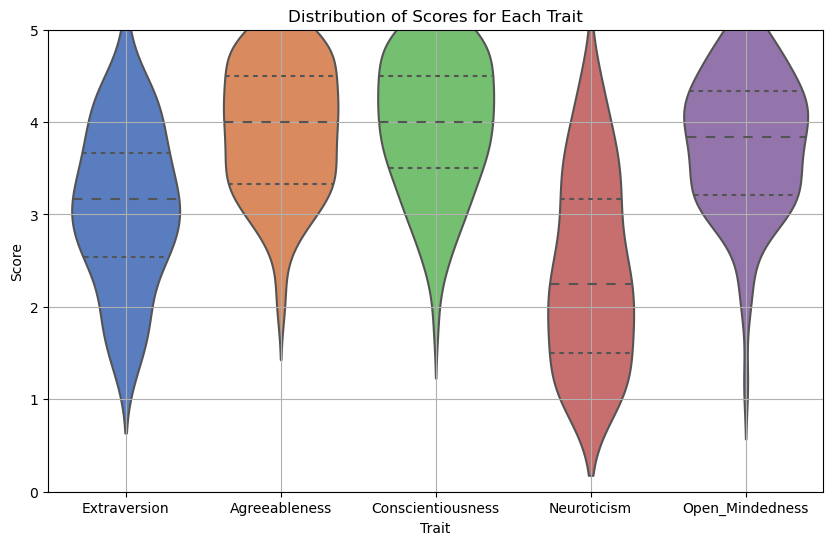

In [14]:
# Melt the DataFrame
big5_df_num = big5_df.iloc[:,1:]
big5_df_melted = big5_df_num.melt(var_name='Trait', value_name='Score')

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Trait', y='Score', data=big5_df_melted, inner='quartile', palette='muted')
plt.title('Distribution of Scores for Each Trait')
plt.ylim(0, 5)
plt.xlabel('Trait')
plt.ylabel('Score')
plt.grid(True)

# Show the plot
plt.show()

## generating distance for a single trait and blended traits

In [15]:
"""
# Extract rows where all Big 5 scores are greater than 3
big5_df_high_scorers = big5_df[
                               (big5_df['Extraversion'] > 3) & 
                               (big5_df['Agreeableness'] > 3) & 
                               (big5_df['Conscientiousness'] > 3) & 
                               (big5_df['Open_Mindedness'] > 3)
]

# Display the result
print(f"Number of participants with targeted Big 5 scores > 3: {len(big5_df_high_scorers)}")
#print(big5_df_high_scorers)
"""

'\n# Extract rows where all Big 5 scores are greater than 3\nbig5_df_high_scorers = big5_df[\n                               (big5_df[\'Extraversion\'] > 3) & \n                               (big5_df[\'Agreeableness\'] > 3) & \n                               (big5_df[\'Conscientiousness\'] > 3) & \n                               (big5_df[\'Open_Mindedness\'] > 3)\n]\n\n# Display the result\nprint(f"Number of participants with targeted Big 5 scores > 3: {len(big5_df_high_scorers)}")\n#print(big5_df_high_scorers)\n'

In [16]:
"""
# Extract rows where all Big 5 scores are greater than 3
big5_df_ex_high_scorers = big5_df[big5_df['Extraversion'] > 3]['ResponseId'].tolist()
big5_df_ag_high_scorers = big5_df[big5_df['Agreeableness'] > 3]['ResponseId'].tolist()
big5_df_co_high_scorers = big5_df[big5_df['Conscientiousness'] > 3]['ResponseId'].tolist()
big5_df_op_high_scorers = big5_df[big5_df['Open_Mindedness'] > 3]['ResponseId'].tolist()

# Display the result
print(f"Number of participants with op > 3: {len(big5_df_op_high_scorers)}")
print(f"Number of participants with co > 3: {len(big5_df_co_high_scorers)}")
print(f"Number of participants with ex > 3: {len(big5_df_ex_high_scorers)}")
print(f"Number of participants with ag > 3: {len(big5_df_ag_high_scorers)}")

big5_dfs_dict = {}
big5_dfs_dict['op'] = big5_df[big5_df['ResponseId'].isin(big5_df_op_high_scorers)]
big5_dfs_dict['co'] = big5_df[big5_df['ResponseId'].isin(big5_df_co_high_scorers)]
big5_dfs_dict['ex'] = big5_df[big5_df['ResponseId'].isin(big5_df_ex_high_scorers)]
big5_dfs_dict['ag'] = big5_df[big5_df['ResponseId'].isin(big5_df_ag_high_scorers)]
"""

'\n# Extract rows where all Big 5 scores are greater than 3\nbig5_df_ex_high_scorers = big5_df[big5_df[\'Extraversion\'] > 3][\'ResponseId\'].tolist()\nbig5_df_ag_high_scorers = big5_df[big5_df[\'Agreeableness\'] > 3][\'ResponseId\'].tolist()\nbig5_df_co_high_scorers = big5_df[big5_df[\'Conscientiousness\'] > 3][\'ResponseId\'].tolist()\nbig5_df_op_high_scorers = big5_df[big5_df[\'Open_Mindedness\'] > 3][\'ResponseId\'].tolist()\n\n# Display the result\nprint(f"Number of participants with op > 3: {len(big5_df_op_high_scorers)}")\nprint(f"Number of participants with co > 3: {len(big5_df_co_high_scorers)}")\nprint(f"Number of participants with ex > 3: {len(big5_df_ex_high_scorers)}")\nprint(f"Number of participants with ag > 3: {len(big5_df_ag_high_scorers)}")\n\nbig5_dfs_dict = {}\nbig5_dfs_dict[\'op\'] = big5_df[big5_df[\'ResponseId\'].isin(big5_df_op_high_scorers)]\nbig5_dfs_dict[\'co\'] = big5_df[big5_df[\'ResponseId\'].isin(big5_df_co_high_scorers)]\nbig5_dfs_dict[\'ex\'] = big5_df[

In [17]:
"""
socioecono_df_high_op = socioecono_df[socioecono_df['ResponseId'].isin(big5_df_op_high_scorers)]
socioecono_df_high_co = socioecono_df[socioecono_df['ResponseId'].isin(big5_df_co_high_scorers)]
socioecono_df_high_ex = socioecono_df[socioecono_df['ResponseId'].isin(big5_df_ex_high_scorers)]
socioecono_df_high_ag = socioecono_df[socioecono_df['ResponseId'].isin(big5_df_ag_high_scorers)]


print(f"OP: mean age {socioecono_df_high_op['age'].mean()} with sd {socioecono_df_high_op['age'].std()}, female % {socioecono_df_high_op[socioecono_df_high_op['gender']==1]['gender'].sum()/socioecono_df_high_op.shape[0]}")
print(f"CO: mean age {socioecono_df_high_co['age'].mean()} with sd {socioecono_df_high_co['age'].std()}, female % {socioecono_df_high_co[socioecono_df_high_co['gender']==1]['gender'].sum()/socioecono_df_high_co.shape[0]}")
print(f"EX: mean age {socioecono_df_high_ex['age'].mean()} with sd {socioecono_df_high_ex['age'].std()}, female % {socioecono_df_high_ex[socioecono_df_high_ex['gender']==1]['gender'].sum()/socioecono_df_high_ex.shape[0]}")
print(f"AG: mean age {socioecono_df_high_ag['age'].mean()} with sd {socioecono_df_high_ag['age'].std()}, female % {socioecono_df_high_ag[socioecono_df_high_ag['gender']==1]['gender'].sum()/socioecono_df_high_ag.shape[0]}")

socioecono_dfs_dict = {}
socioecono_dfs_dict['op'] = socioecono_df_high_op
socioecono_dfs_dict['co'] = socioecono_df_high_co
socioecono_dfs_dict['ex'] = socioecono_df_high_ex
socioecono_dfs_dict['ag'] = socioecono_df_high_ag
"""

'\nsocioecono_df_high_op = socioecono_df[socioecono_df[\'ResponseId\'].isin(big5_df_op_high_scorers)]\nsocioecono_df_high_co = socioecono_df[socioecono_df[\'ResponseId\'].isin(big5_df_co_high_scorers)]\nsocioecono_df_high_ex = socioecono_df[socioecono_df[\'ResponseId\'].isin(big5_df_ex_high_scorers)]\nsocioecono_df_high_ag = socioecono_df[socioecono_df[\'ResponseId\'].isin(big5_df_ag_high_scorers)]\n\n\nprint(f"OP: mean age {socioecono_df_high_op[\'age\'].mean()} with sd {socioecono_df_high_op[\'age\'].std()}, female % {socioecono_df_high_op[socioecono_df_high_op[\'gender\']==1][\'gender\'].sum()/socioecono_df_high_op.shape[0]}")\nprint(f"CO: mean age {socioecono_df_high_co[\'age\'].mean()} with sd {socioecono_df_high_co[\'age\'].std()}, female % {socioecono_df_high_co[socioecono_df_high_co[\'gender\']==1][\'gender\'].sum()/socioecono_df_high_co.shape[0]}")\nprint(f"EX: mean age {socioecono_df_high_ex[\'age\'].mean()} with sd {socioecono_df_high_ex[\'age\'].std()}, female % {socioecono

In [18]:
mixed_trait_scores = pd.read_csv('raw/mixed_trait_scores.csv')
mixed_trait_scores

Extraversion  Agreeableness  Conscientiousness  Open_Mindedness
0      3.166667            4.0                4.0         3.833333

In [19]:
big5_dict = {'op': 'Open_Mindedness',
             'co': 'Conscientiousness',
             'ex': 'Extraversion',
             'ag': 'Agreeableness'}


In [20]:
def calculate_distance(df, mixed_scores, trait):
    trait_full = big5_dict[trait]
    return np.abs(df[trait_full] - mixed_scores[trait_full].values[0])

def calculate_distance_from_max(df, trait):
    trait_full = big5_dict[trait]
    return 5 - df[trait_full]

def generate_big5_distance_df(big5_df, mixed_trait_scores):
    distances = pd.DataFrame(index=big5_df.index)
    
    for trait in big5_dict.keys():
        distances[f'{trait}_distance'] = calculate_distance(big5_df, mixed_trait_scores, trait)
        distances[f'{trait}_distance_from_max'] = calculate_distance_from_max(big5_df, trait)
    
    distances['total_distance'] = distances[[f'{trait}_distance' for trait in big5_dict.keys()]].sum(axis=1)
    
    distance_columns = [f'{trait}_distance' for trait in big5_dict.keys()]
    distances['average_distance'] = distances[distance_columns].mean(axis=1)
    
    return pd.concat([big5_df['ResponseId'], distances], axis=1)

def generate_big5_distance_type_df(df, mixed_trait_scores):
    distances = pd.DataFrame(index=df.index)
    
    for trait in big5_dict.keys():
        distances[f'{trait}_distance'] = calculate_distance(df, mixed_trait_scores, trait)
        distances[f'{trait}_distance_from_max'] = calculate_distance_from_max(df, trait)
    
    distances['total_distance'] = distances[[f'{trait}_distance' for trait in big5_dict.keys()]].sum(axis=1)
    
    distance_columns = [f'{trait}_distance' for trait in big5_dict.keys()]
    distances['average_distance'] = distances[distance_columns].mean(axis=1)
    
    return pd.concat([df['ResponseId'], distances], axis=1)

# Generate big5_distance_df for all respondents
big5_distance_df = generate_big5_distance_df(big5_df, mixed_trait_scores)

# Generate big5_distance_{type} for each type (20240727 ceased)
"""
big5_distance_dfs_dict = {}
for type, df in big5_dfs_dict.items():
    big5_distance_dfs_dict[type] = generate_big5_distance_type_df(df, mixed_trait_scores)
    globals()[f'big5_distance_{type}'] = big5_distance_dfs_dict[type]
"""

# Display summary statistics for the comprehensive DataFrame
print("Summary for all responses:")
print(big5_distance_df.describe())
print("\n")

# Display top 5 closest participants based on total distance for all responses
print("Top 5 closest participants for all responses based on total distance:")
print(big5_distance_df.sort_values('total_distance').head())
print("\n" + "="*50 + "\n")

Summary for all responses:
       op_distance  op_distance_from_max  co_distance  co_distance_from_max  \
count    90.000000             90.000000    90.000000             90.000000   
mean      0.587037              1.235185     0.609259              1.038889   
std       0.440766              0.733493     0.423381              0.743700   
min       0.000000              0.000000     0.000000              0.000000   
25%       0.333333              0.666667     0.333333              0.500000   
50%       0.500000              1.166667     0.500000              1.000000   
75%       0.833333              1.791667     0.833333              1.500000   
max       2.666667              3.833333     2.166667              3.166667   

       ex_distance  ex_distance_from_max  ag_distance  ag_distance_from_max  \
count    90.000000             90.000000    90.000000             90.000000   
mean      0.694444              1.920370     0.585185              1.081481   
std       0.509124      

<Axes: >

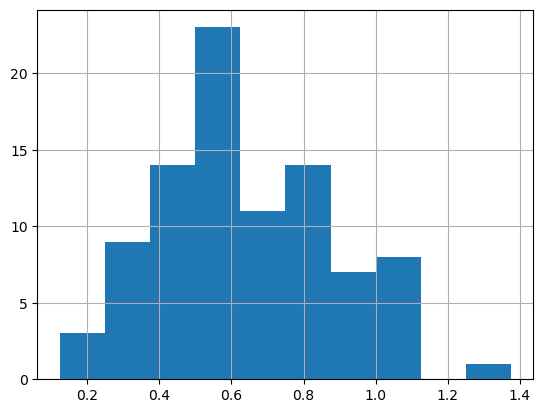

In [21]:
big5_distance_df['average_distance'].hist()

## Introduce a merged_df

All recorded by ResponseId
- **s3_response_df**   : has all of the 0 - 100 scale scores from the survey
- **big5_distance_df** : (1) distances for each trait from the benchmark scores(median) of a blended personality.  (2) distances for each trait from the max score(=5). (3) total and average distances from the benchmark scores of a blended personality
- **socioecono_df**    : socio economic scores

In [22]:
big5_distance_df.head(1)

ResponseId  op_distance  op_distance_from_max  co_distance  \
1  641357b26802e397b5627d5e     0.333333              0.833333     0.166667   

   co_distance_from_max  ex_distance  ex_distance_from_max  ag_distance  \
1              0.833333     0.666667              1.166667     0.833333   

   ag_distance_from_max  total_distance  average_distance  
1              1.833333             2.0               0.5

In [23]:
s3_response_df.head(1)

ResponseId  Ads_OP_1  Ads_OP_2  Ads_OP_3  Ads_OP_4  \
12  577f70d1454e5400015f1845        72        59        70        34   

    Ads_OP_5  Ads_OP_6  Ads_CO_1  Ads_CO_2  Ads_CO_3  Ads_CO_4  Ads_CO_5  \
12        88        83        88        85        91        87        95   

    Ads_CO_6  Ads_EX_1  Ads_EX_2  Ads_EX_3  Ads_EX_4  Ads_EX_5  Ads_EX_6  \
12        93         7        29        36         5        20        10   

    Ads_AG_1  Ads_AG_2  Ads_AG_3  Ads_AG_4  Ads_AG_5  Ads_AG_6  Desc_OP_1  \
12        82        89        91        88        91        91         91   

    Desc_CO_1  Desc_EX_1  Desc_AG_1  
12         85         88          6

In [24]:
# Merge big5_distance_df, s3_response_df, and socioecono_df on ResponseId
merged_df = pd.merge(big5_distance_df, s3_response_df, on='ResponseId', how='inner')
merged_df = pd.merge(merged_df, socioecono_df, on='ResponseId', how='inner')

# Rename columns in the merged dataframe
column_mapping = {
    'op_distance': 'OP_distance',
    'op_distance_from_max': 'OP_distance_from_max',
    'co_distance': 'CO_distance',
    'co_distance_from_max': 'CO_distance_from_max',
    'ex_distance': 'EX_distance',
    'ex_distance_from_max': 'EX_distance_from_max',
    'ag_distance': 'AG_distance',
    'ag_distance_from_max': 'AG_distance_from_max'
}

merged_df = merged_df.rename(columns=column_mapping)

# Display the column names to verify the changes
print("\nColumn names:")
print(merged_df.columns)



Column names:
Index(['ResponseId', 'OP_distance', 'OP_distance_from_max', 'CO_distance',
       'CO_distance_from_max', 'EX_distance', 'EX_distance_from_max',
       'AG_distance', 'AG_distance_from_max', 'total_distance',
       'average_distance', 'Ads_OP_1', 'Ads_OP_2', 'Ads_OP_3', 'Ads_OP_4',
       'Ads_OP_5', 'Ads_OP_6', 'Ads_CO_1', 'Ads_CO_2', 'Ads_CO_3', 'Ads_CO_4',
       'Ads_CO_5', 'Ads_CO_6', 'Ads_EX_1', 'Ads_EX_2', 'Ads_EX_3', 'Ads_EX_4',
       'Ads_EX_5', 'Ads_EX_6', 'Ads_AG_1', 'Ads_AG_2', 'Ads_AG_3', 'Ads_AG_4',
       'Ads_AG_5', 'Ads_AG_6', 'Desc_OP_1', 'Desc_CO_1', 'Desc_EX_1',
       'Desc_AG_1', 'gender', 'age', 'education', 'race', 'employment',
       'income'],
      dtype='object')


introduce normalized merged_df

array([[<Axes: title={'center': 'OP_distance'}>,
        <Axes: title={'center': 'OP_distance_from_max'}>,
        <Axes: title={'center': 'CO_distance'}>],
       [<Axes: title={'center': 'CO_distance_from_max'}>,
        <Axes: title={'center': 'EX_distance'}>,
        <Axes: title={'center': 'EX_distance_from_max'}>],
       [<Axes: title={'center': 'AG_distance'}>,
        <Axes: title={'center': 'AG_distance_from_max'}>,
        <Axes: title={'center': 'total_distance'}>],
       [<Axes: title={'center': 'average_distance'}>, <Axes: >, <Axes: >]],
      dtype=object)

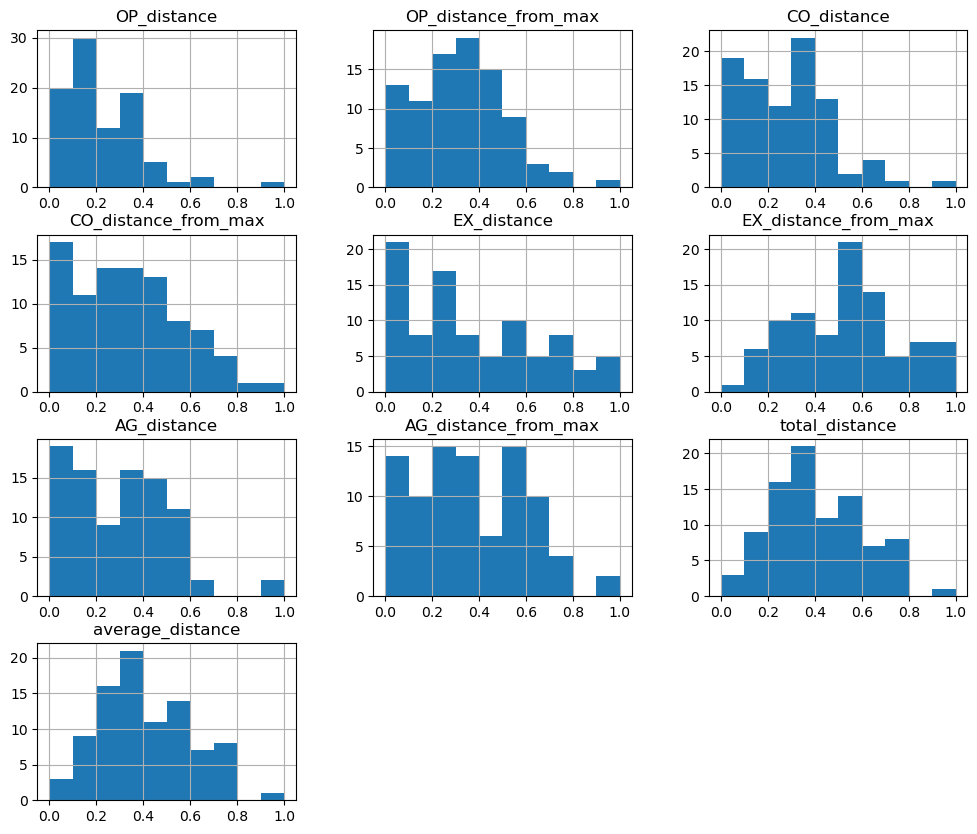

In [25]:
# Define the columns to normalize
columns_to_normalize = [
    'OP_distance', 'OP_distance_from_max', 'CO_distance', 'CO_distance_from_max',
    'EX_distance', 'EX_distance_from_max', 'AG_distance', 'AG_distance_from_max',
    'total_distance', 'average_distance'
]

# Create a new DataFrame with normalized columns
merged_df_norm = merged_df.copy()

# Normalize the specified columns
for column in columns_to_normalize:
    merged_df_norm[column] = (merged_df_norm[column] - merged_df_norm[column].min()) / (merged_df_norm[column].max() - merged_df_norm[column].min())

merged_df_norm[columns_to_normalize].hist(figsize= (12,10))


In [26]:
merged_df.head(1)

ResponseId  OP_distance  OP_distance_from_max  CO_distance  \
0  641357b26802e397b5627d5e     0.333333              0.833333     0.166667   

   CO_distance_from_max  EX_distance  EX_distance_from_max  AG_distance  \
0              0.833333     0.666667              1.166667     0.833333   

   AG_distance_from_max  total_distance  average_distance  Ads_OP_1  Ads_OP_2  \
0              1.833333             2.0               0.5        89        75   

   Ads_OP_3  Ads_OP_4  Ads_OP_5  Ads_OP_6  Ads_CO_1  Ads_CO_2  Ads_CO_3  \
0        89        84        71        75        81        66        74   

   Ads_CO_4  Ads_CO_5  Ads_CO_6  Ads_EX_1  Ads_EX_2  Ads_EX_3  Ads_EX_4  \
0        77        79        82        72        68        67        68   

   Ads_EX_5  Ads_EX_6  Ads_AG_1  Ads_AG_2  Ads_AG_3  Ads_AG_4  Ads_AG_5  \
0        76        69        71        78        70        68        85   

   Ads_AG_6  Desc_OP_1  Desc_CO_1  Desc_EX_1  Desc_AG_1  gender  age  \
0        84         63         50         53         50       1   36   

   education  race  employment  income  
0          5     1           7       7

In [27]:
merged_df_norm.head(1)

ResponseId  OP_distance  OP_distance_from_max  CO_distance  \
0  641357b26802e397b5627d5e        0.125              0.217391     0.076923   

   CO_distance_from_max  EX_distance  EX_distance_from_max  AG_distance  \
0              0.263158     0.363636              0.318182     0.416667   

   AG_distance_from_max  total_distance  average_distance  Ads_OP_1  Ads_OP_2  \
0              0.611111             0.3               0.3        89        75   

   Ads_OP_3  Ads_OP_4  Ads_OP_5  Ads_OP_6  Ads_CO_1  Ads_CO_2  Ads_CO_3  \
0        89        84        71        75        81        66        74   

   Ads_CO_4  Ads_CO_5  Ads_CO_6  Ads_EX_1  Ads_EX_2  Ads_EX_3  Ads_EX_4  \
0        77        79        82        72        68        67        68   

   Ads_EX_5  Ads_EX_6  Ads_AG_1  Ads_AG_2  Ads_AG_3  Ads_AG_4  Ads_AG_5  \
0        76        69        71        78        70        68        85   

   Ads_AG_6  Desc_OP_1  Desc_CO_1  Desc_EX_1  Desc_AG_1  gender  age  \
0        84         63         50         53         50       1   36   

   education  race  employment  income  
0          5     1           7       7

## Further data processing

In [28]:
merged_df.columns

Index(['ResponseId', 'OP_distance', 'OP_distance_from_max', 'CO_distance',
       'CO_distance_from_max', 'EX_distance', 'EX_distance_from_max',
       'AG_distance', 'AG_distance_from_max', 'total_distance',
       'average_distance', 'Ads_OP_1', 'Ads_OP_2', 'Ads_OP_3', 'Ads_OP_4',
       'Ads_OP_5', 'Ads_OP_6', 'Ads_CO_1', 'Ads_CO_2', 'Ads_CO_3', 'Ads_CO_4',
       'Ads_CO_5', 'Ads_CO_6', 'Ads_EX_1', 'Ads_EX_2', 'Ads_EX_3', 'Ads_EX_4',
       'Ads_EX_5', 'Ads_EX_6', 'Ads_AG_1', 'Ads_AG_2', 'Ads_AG_3', 'Ads_AG_4',
       'Ads_AG_5', 'Ads_AG_6', 'Desc_OP_1', 'Desc_CO_1', 'Desc_EX_1',
       'Desc_AG_1', 'gender', 'age', 'education', 'race', 'employment',
       'income'],
      dtype='object')

In [29]:
# データの読み込み（既存のデータフレームを 'data' とします）

# 1. 相対的選好スコアの作成
traits = ['EX', 'OP', 'CO', 'AG']
for trait in traits:
    merged_df[f'Desc_{trait}_relative_1'] = merged_df[f'Desc_{trait}_1'] - 50
    merged_df_norm[f'Desc_{trait}_relative_1'] = merged_df_norm[f'Desc_{trait}_1'] - 50
    for i in range(1, 7):
        merged_df[f'Ads_{trait}_relative_{i}'] = merged_df[f'Ads_{trait}_{i}'] - 50
        merged_df_norm[f'Ads_{trait}_relative_{i}'] = merged_df_norm[f'Ads_{trait}_{i}'] - 50

   

# sandbox 1

In [30]:
data = merged_df

"""
マルチレベルモデルは、個人内での広告タイプの効果と個人間での特性の効果を同時に分析します。
これにより、Blended Personality広告が全体的にどの程度好まれるか、
また特定の特性や条件下でどのように効果が変化するかを理解できます。
"""
# b. マルチレベルモデル
data_long = pd.melt(data, 
                    id_vars=['ResponseId', 'EX_distance_from_max', 'OP_distance_from_max', 
                             'CO_distance_from_max', 'AG_distance_from_max', 'average_distance'],
                    value_vars=[col for col in data.columns if col.startswith('Ads_') and col.endswith(('1', '2', '3', '4', '5', '6'))],
                    var_name='ad_type', value_name='preference_score')

data_long['is_blended'] = ~data_long['ad_type'].str.endswith('1')
data_long['trait'] = data_long['ad_type'].str.split('_').str[1]
data_long['question_type'] = data_long['ad_type'].str.split('_').str[2]

model = smf.mixedlm("preference_score ~ is_blended + trait + question_type + is_blended:trait + average_distance", 
                    data=data_long, groups=data_long["ResponseId"])
results = model.fit()
print(results.summary())

                    Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      preference_score
No. Observations:      4320         Method:                  REML            
No. Groups:            90           Scale:                   688.0615        
Min. group size:       48           Log-Likelihood:          -20343.6394     
Max. group size:       48           Converged:               Yes             
Mean group size:       48.0                                                  
-----------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------------
Intercept                       53.850    5.069  10.624 0.000  43.915  63.785
is_blended[T.True]              -0.069    2.395  -0.029 0.977  -4.762   4.624
trait[T.CO]                    -11.111    2.765  -4.019 0.000 -16.530  -5.692
trait[

In [31]:
merged_df_norm.columns

Index(['ResponseId', 'OP_distance', 'OP_distance_from_max', 'CO_distance',
       'CO_distance_from_max', 'EX_distance', 'EX_distance_from_max',
       'AG_distance', 'AG_distance_from_max', 'total_distance',
       'average_distance', 'Ads_OP_1', 'Ads_OP_2', 'Ads_OP_3', 'Ads_OP_4',
       'Ads_OP_5', 'Ads_OP_6', 'Ads_CO_1', 'Ads_CO_2', 'Ads_CO_3', 'Ads_CO_4',
       'Ads_CO_5', 'Ads_CO_6', 'Ads_EX_1', 'Ads_EX_2', 'Ads_EX_3', 'Ads_EX_4',
       'Ads_EX_5', 'Ads_EX_6', 'Ads_AG_1', 'Ads_AG_2', 'Ads_AG_3', 'Ads_AG_4',
       'Ads_AG_5', 'Ads_AG_6', 'Desc_OP_1', 'Desc_CO_1', 'Desc_EX_1',
       'Desc_AG_1', 'gender', 'age', 'education', 'race', 'employment',
       'income', 'Desc_EX_relative_1', 'Ads_EX_relative_1',
       'Ads_EX_relative_2', 'Ads_EX_relative_3', 'Ads_EX_relative_4',
       'Ads_EX_relative_5', 'Ads_EX_relative_6', 'Desc_OP_relative_1',
       'Ads_OP_relative_1', 'Ads_OP_relative_2', 'Ads_OP_relative_3',
       'Ads_OP_relative_4', 'Ads_OP_relative_5', 'Ads_OP_relative_

Cluster Analysis Results:
Cluster 0 (Size: 38):
  - EX_distance_from_max: Medium (0.50)
  - OP_distance_from_max: Low (0.27)
  - CO_distance_from_max: Medium (0.37)
  - AG_distance_from_max: Medium (0.40)
  - average_distance: Low (0.23)

Cluster 1 (Size: 30):
  - EX_distance_from_max: Medium (0.42)
  - OP_distance_from_max: Low (0.31)
  - CO_distance_from_max: Low (0.08)
  - AG_distance_from_max: Low (0.19)
  - average_distance: Medium (0.46)

Cluster 2 (Size: 22):
  - EX_distance_from_max: High (0.70)
  - OP_distance_from_max: Medium (0.43)
  - CO_distance_from_max: Medium (0.60)
  - AG_distance_from_max: Medium (0.52)
  - average_distance: Medium (0.59)



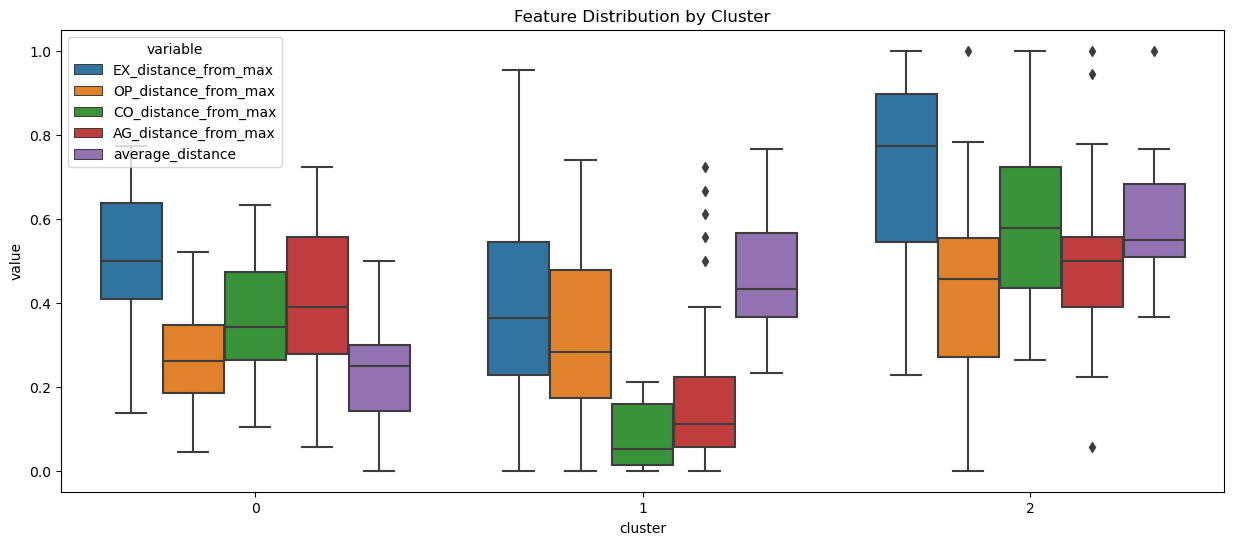


Ad Preference Analysis by Cluster:
          Ads_OP_1   Ads_CO_1   Ads_EX_1   Ads_AG_1
cluster                                            
0        45.210526  50.842105  47.736842  55.894737
1        39.800000  45.066667  54.133333  68.200000
2        47.409091  47.727273  61.954545  52.909091


In [32]:
"""
潜在クラス分析は、回答者を類似した特性と広告選好を持つグループに分類します。
これにより、Blended Personality広告がどのようなタイプの人々により効果的であるかを
探索的に理解することができ、GPT-4の広告生成能力の強みと限界を明らかにするのに役立ちます。
"""

data = merged_df_norm

# c. 潜在クラス分析（ここではGaussian Mixture Modelを使用）
# 特徴量の選択
features = ['EX_distance_from_max', 'OP_distance_from_max', 
            'CO_distance_from_max', 'AG_distance_from_max', 
            'average_distance']
X = data[features]
X_scaled = StandardScaler().fit_transform(X)

# モデルの適合
gmm = GaussianMixture(n_components=3, random_state=42)
data['cluster'] = gmm.fit_predict(X_scaled)

# クラスターごとの特徴を分析
cluster_means = data.groupby('cluster')[features].mean()
cluster_sizes = data['cluster'].value_counts().sort_index()

# クラスターの特徴を記述
cluster_descriptions = []
for i in range(3):
    description = f"Cluster {i} (Size: {cluster_sizes[i]}):\n"
    for feature in features:
        value = cluster_means.loc[i, feature]
        if value < 0.33:
            level = "Low"
        elif value < 0.66:
            level = "Medium"
        else:
            level = "High"
        description += f"  - {feature}: {level} ({value:.2f})\n"
    cluster_descriptions.append(description)

# 結果の表示
print("Cluster Analysis Results:")
for desc in cluster_descriptions:
    print(desc)

# クラスターごとの特徴を可視化
plt.figure(figsize=(15, 6))
sns.boxplot(x='cluster', y='value', hue='variable', 
            data=pd.melt(data[features + ['cluster']], id_vars='cluster'))
plt.title('Feature Distribution by Cluster')
plt.show()

# 各クラスターの広告選好スコアの分析
ad_preference_columns = ['Ads_OP_1', 'Ads_CO_1', 'Ads_EX_1', 'Ads_AG_1']
cluster_ad_preferences = data.groupby('cluster')[ad_preference_columns].mean()

print("\nAd Preference Analysis by Cluster:")
print(cluster_ad_preferences)

In [33]:
"""
閾値を用いた分析は、Blended Personality広告の効果が特定の条件下で
どのように変化するかを明らかにします。これは、GPT-4が生成する広告の
効果が、ターゲットとなる個人の特性プロファイルにどの程度依存するかを
理解するのに役立ちます。
"""

# d. 閾値を用いた分析
data['high_average_distance'] = data['average_distance'] > data['average_distance'].median()

for trait in ['EX', 'OP', 'CO', 'AG']:
    t_stat, p_value = stats.ttest_ind(
        data[data['high_average_distance']][f'{trait}_distance_from_max'],
        data[~data['high_average_distance']][f'{trait}_distance_from_max']
    )
    print(f"\n{trait} - T-test for diff_score between high and low average_distance groups:")
    print(f"T-statistic: {t_stat}, P-value: {p_value}")


EX - T-test for diff_score between high and low average_distance groups:
T-statistic: 0.5110244644294054, P-value: 0.6106136565091842

OP - T-test for diff_score between high and low average_distance groups:
T-statistic: 2.0663022737233403, P-value: 0.041739572451391316

CO - T-test for diff_score between high and low average_distance groups:
T-statistic: 0.42209045125055644, P-value: 0.6739884283984843

AG - T-test for diff_score between high and low average_distance groups:
T-statistic: 0.24795385903302972, P-value: 0.8047477716211742


# sandbox 2 (final?)


Interaction analysis for EX:
                            OLS Regression Results                            
Dep. Variable:      Ads_EX_relative_1   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     3.460
Date:                Sun, 28 Jul 2024   Prob (F-statistic):             0.0198
Time:                        07:49:44   Log-Likelihood:                -437.85
No. Observations:                  90   AIC:                             883.7
Df Residuals:                      86   BIC:                             893.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

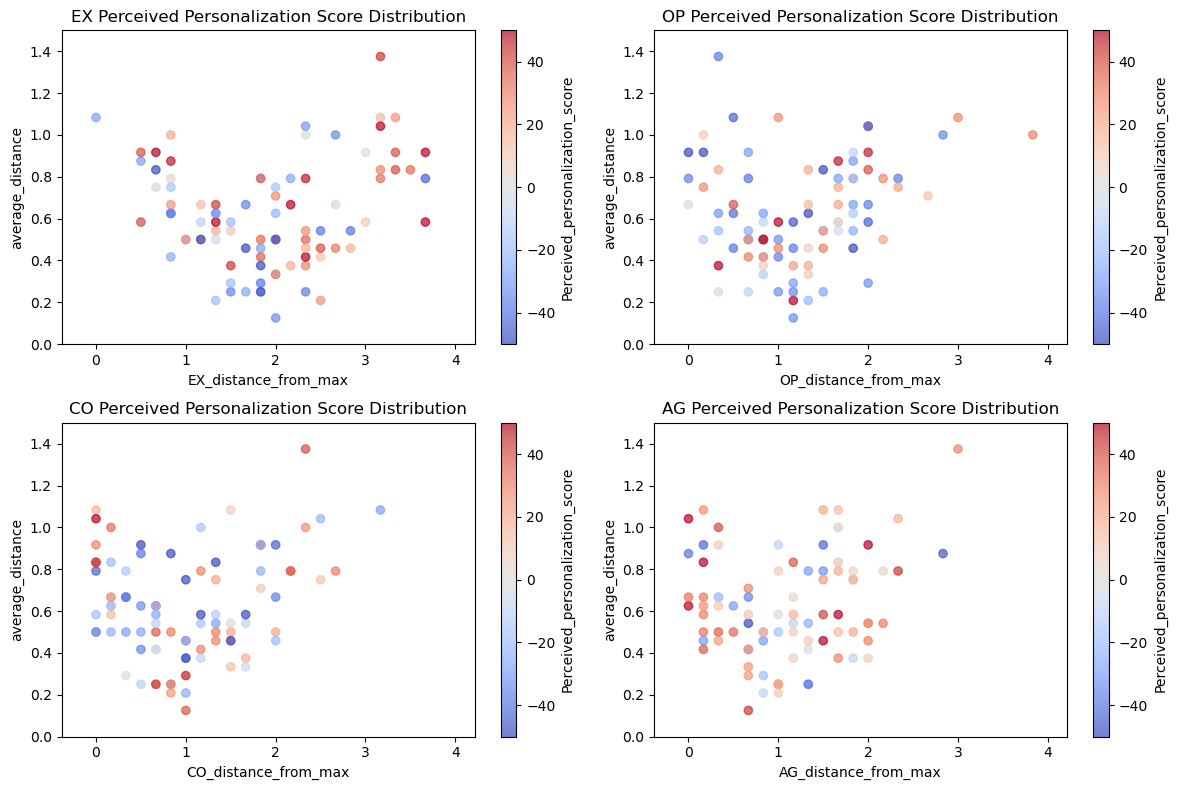

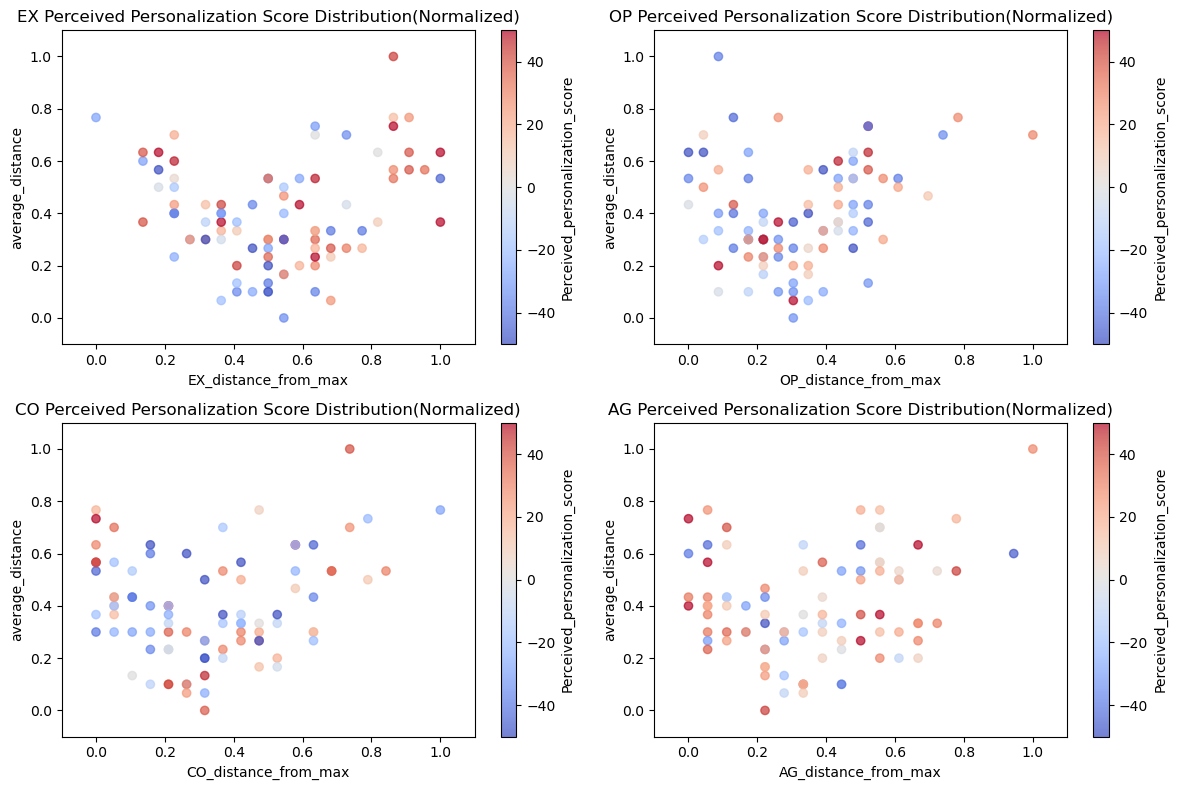

In [34]:
# 6. 交互作用効果の分析
def analyze_interactions(trait, data):
    model = smf.ols(f'Ads_{trait}_relative_1 ~ {trait}_distance_from_max * average_distance', data=data)
    results = model.fit()
    print(f"\nInteraction analysis for {trait}:")
    print(results.summary())

for trait in ['EX', 'OP', 'CO', 'AG']:
    analyze_interactions(trait, merged_df_norm)

# 可視化2
def scatter_plot_2 (data, scaled = ""):
    plt.figure(figsize=(12, 8))

    # 全てのTraitの中での最大値と最小値を計算
    x_min = min(data[f'{trait}_distance_from_max'].min() for trait in ['EX', 'OP', 'CO', 'AG'])
    x_max = max(data[f'{trait}_distance_from_max'].max() for trait in ['EX', 'OP', 'CO', 'AG'])
    y_min = data['average_distance'].min()
    y_max = data['average_distance'].max()

    # マージンを追加
    margin = 0.1
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= margin * x_range
    x_max += margin * x_range
    y_min -= margin * y_range
    y_max += margin * y_range

    for i, trait in enumerate(['EX', 'OP', 'CO', 'AG']):
        plt.subplot(2, 2, i+1)
        
        scatter = plt.scatter(data[f'{trait}_distance_from_max'], 
                            data['average_distance'],
                            c=data[f'Ads_{trait}_relative_1'], 
                            cmap='coolwarm', 
                            alpha=0.7)
        plt.colorbar(scatter, label=f'Perceived_personalization_score')
        plt.xlabel(f'{trait}_distance_from_max')
        plt.ylabel('average_distance')
        plt.title(f'{trait} Perceived Personalization Score Distribution{scaled}')
        
        # 全てのチャートで同じX軸とY軸の範囲を設定
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

    plt.tight_layout()
    plt.show()

scatter_plot_2 (merged_df, scaled = "")
scatter_plot_2 (merged_df_norm, scaled = '(Normalized)')



In [35]:
merged_df_norm.tail(1)

ResponseId  OP_distance  OP_distance_from_max  CO_distance  \
89  6658822c0f5b1367a1585ee1         0.25              0.478261     0.461538   

    CO_distance_from_max  EX_distance  EX_distance_from_max  AG_distance  \
89                   0.0     0.727273              0.136364     0.333333   

    AG_distance_from_max  total_distance  average_distance  Ads_OP_1  \
89              0.111111        0.633333          0.633333        40   

    Ads_OP_2  Ads_OP_3  Ads_OP_4  Ads_OP_5  Ads_OP_6  Ads_CO_1  Ads_CO_2  \
89        50        40        40        40        40        80        80   

    Ads_CO_3  Ads_CO_4  Ads_CO_5  Ads_CO_6  Ads_EX_1  Ads_EX_2  Ads_EX_3  \
89        80        85        90        90        90        50        90   

    Ads_EX_4  Ads_EX_5  Ads_EX_6  Ads_AG_1  Ads_AG_2  Ads_AG_3  Ads_AG_4  \
89        80       100        90        60        70        60        50   

    Ads_AG_5  Ads_AG_6  Desc_OP_1  Desc_CO_1  Desc_EX_1  Desc_AG_1  gender  \
89        70        70         40         70         60         70       2   

    age  education  race  employment  income  Desc_EX_relative_1  \
89   43          5     2           7       8                  10   

    Ads_EX_relative_1  Ads_EX_relative_2  Ads_EX_relative_3  \
89                 40                  0                 40   

    Ads_EX_relative_4  Ads_EX_relative_5  Ads_EX_relative_6  \
89                 30                 50                 40   

    Desc_OP_relative_1  Ads_OP_relative_1  Ads_OP_relative_2  \
89                 -10                -10                  0   

    Ads_OP_relative_3  Ads_OP_relative_4  Ads_OP_relative_5  \
89                -10                -10                -10   

    Ads_OP_relative_6  Desc_CO_relative_1  Ads_CO_relative_1  \
89                -10                  20                 30   

    Ads_CO_relative_2  Ads_CO_relative_3  Ads_CO_relative_4  \
89                 30                 30                 35   

    Ads_CO_relative_5  Ads_CO_relative_6  Desc_AG_relative_1  \
89                 40                 40                  20   

    Ads_AG_relative_1  Ads_AG_relative_2  Ads_AG_relative_3  \
89                 10                 20                 10   

    Ads_AG_relative_4  Ads_AG_relative_5  Ads_AG_relative_6  cluster  \
89                  0                 20                 20        1   

    high_average_distance  
89                   True

In [36]:
merged_df_norm.dtypes

ResponseId                object
OP_distance              float64
OP_distance_from_max     float64
CO_distance              float64
CO_distance_from_max     float64
                          ...   
Ads_AG_relative_4          int64
Ads_AG_relative_5          int64
Ads_AG_relative_6          int64
cluster                    int64
high_average_distance       bool
Length: 75, dtype: object


Analysis Results for EX:

Section: High-High
N: 23
Mean: 13.74
95% CI: (1.04, 25.65)
P-value: 0.0464
Cohen's d: 0.45
Preferred Ad Type: Blended

Section: Low-High
N: 20
Mean: -3.10
95% CI: (-17.55, 11.80)
P-value: 0.6938
Cohen's d: -0.09
Preferred Ad Type: Single Trait

Section: Low-Low
N: 26
Mean: -7.00
95% CI: (-19.27, 5.54)
P-value: 0.2826
Cohen's d: -0.22
Preferred Ad Type: Single Trait

Section: High-Low
N: 21
Mean: 10.90
95% CI: (-3.19, 24.14)
P-value: 0.1414
Cohen's d: 0.34
Preferred Ad Type: Blended

Linear Regression Results:
                              OLS Regression Results                              
Dep. Variable:     Q("Ads_EX_relative_1")   R-squared:                       0.115
Model:                                OLS   Adj. R-squared:                  0.073
Method:                     Least Squares   F-statistic:                     2.754
Date:                    Sun, 28 Jul 2024   Prob (F-statistic):             0.0331
Time:                            07:49:49  

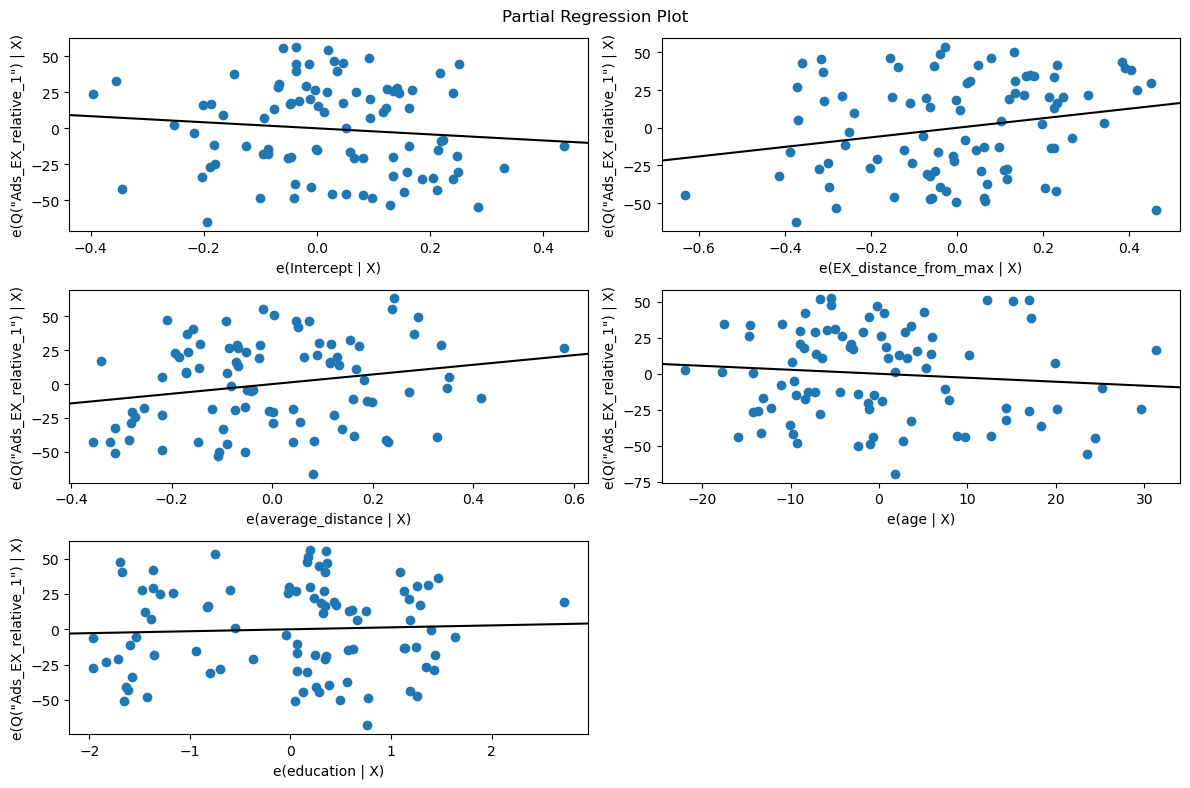

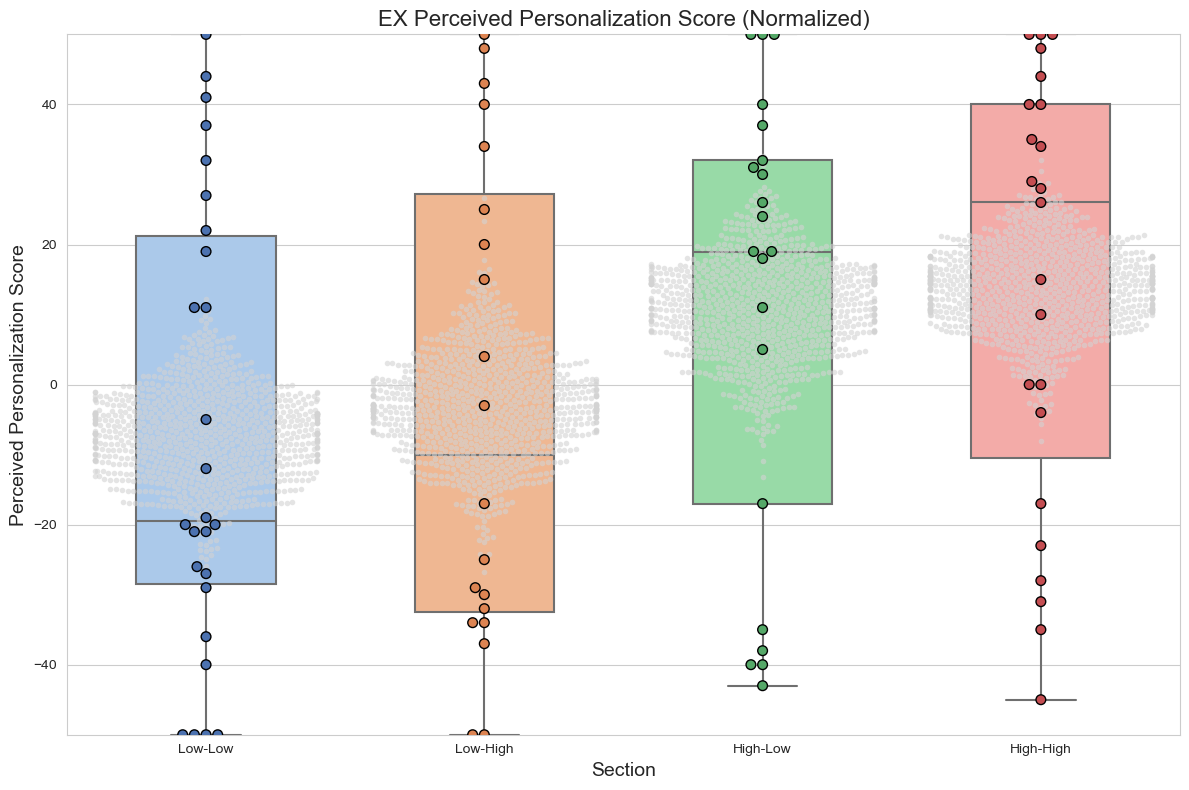


Analysis Results for OP:

Section: High-High
N: 27
Mean: 0.41
95% CI: (-11.82, 12.41)
P-value: 0.9491
Cohen's d: 0.01
Preferred Ad Type: Blended

Section: Low-High
N: 16
Mean: -16.88
95% CI: (-31.88, -1.19)
P-value: 0.0507
Cohen's d: -0.55
Preferred Ad Type: Single Trait

Section: Low-Low
N: 32
Mean: -5.12
95% CI: (-16.41, 6.56)
P-value: 0.3921
Cohen's d: -0.16
Preferred Ad Type: Single Trait

Section: High-Low
N: 15
Mean: -8.13
95% CI: (-21.20, 4.60)
P-value: 0.2568
Cohen's d: -0.32
Preferred Ad Type: Single Trait

Linear Regression Results:
                              OLS Regression Results                              
Dep. Variable:     Q("Ads_OP_relative_1")   R-squared:                       0.024
Model:                                OLS   Adj. R-squared:                 -0.022
Method:                     Least Squares   F-statistic:                    0.5214
Date:                    Sun, 28 Jul 2024   Prob (F-statistic):              0.720
Time:                            07

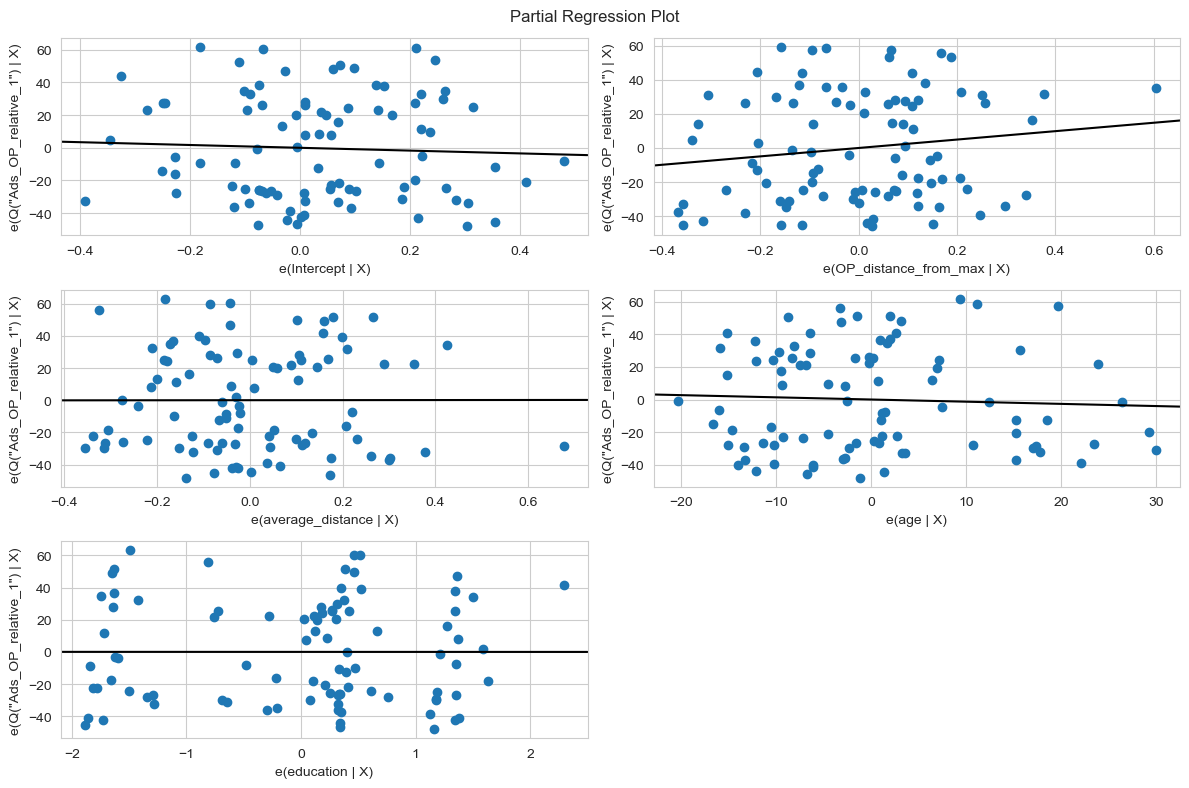

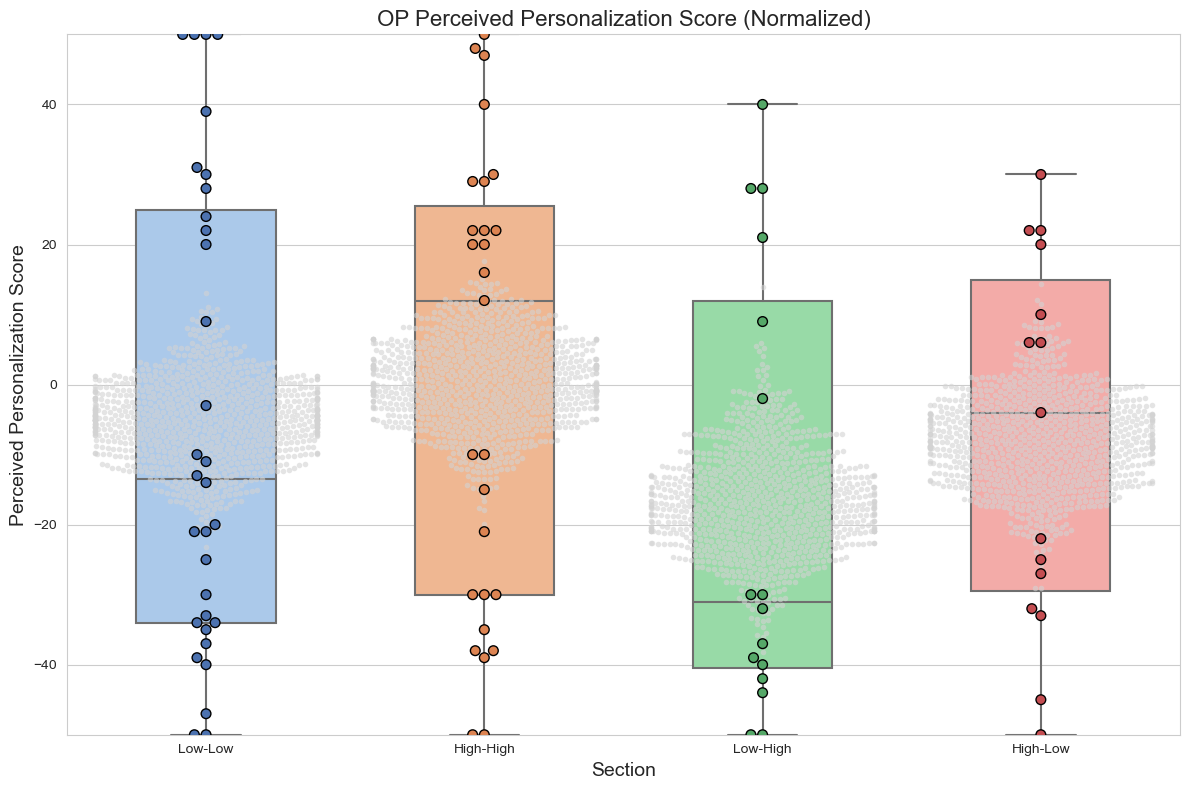


Analysis Results for CO:

Section: High-High
N: 20
Mean: 0.65
95% CI: (-13.75, 14.90)
P-value: 0.9319
Cohen's d: 0.02
Preferred Ad Type: Blended

Section: Low-High
N: 23
Mean: -4.39
95% CI: (-18.87, 10.17)
P-value: 0.5682
Cohen's d: -0.12
Preferred Ad Type: Single Trait

Section: Low-Low
N: 27
Mean: -2.59
95% CI: (-13.48, 8.48)
P-value: 0.6530
Cohen's d: -0.09
Preferred Ad Type: Single Trait

Section: High-Low
N: 20
Mean: -0.40
95% CI: (-11.55, 10.05)
P-value: 0.9445
Cohen's d: -0.02
Preferred Ad Type: Single Trait

Linear Regression Results:
                              OLS Regression Results                              
Dep. Variable:     Q("Ads_CO_relative_1")   R-squared:                       0.025
Model:                                OLS   Adj. R-squared:                 -0.021
Method:                     Least Squares   F-statistic:                    0.5363
Date:                    Sun, 28 Jul 2024   Prob (F-statistic):              0.709
Time:                            07

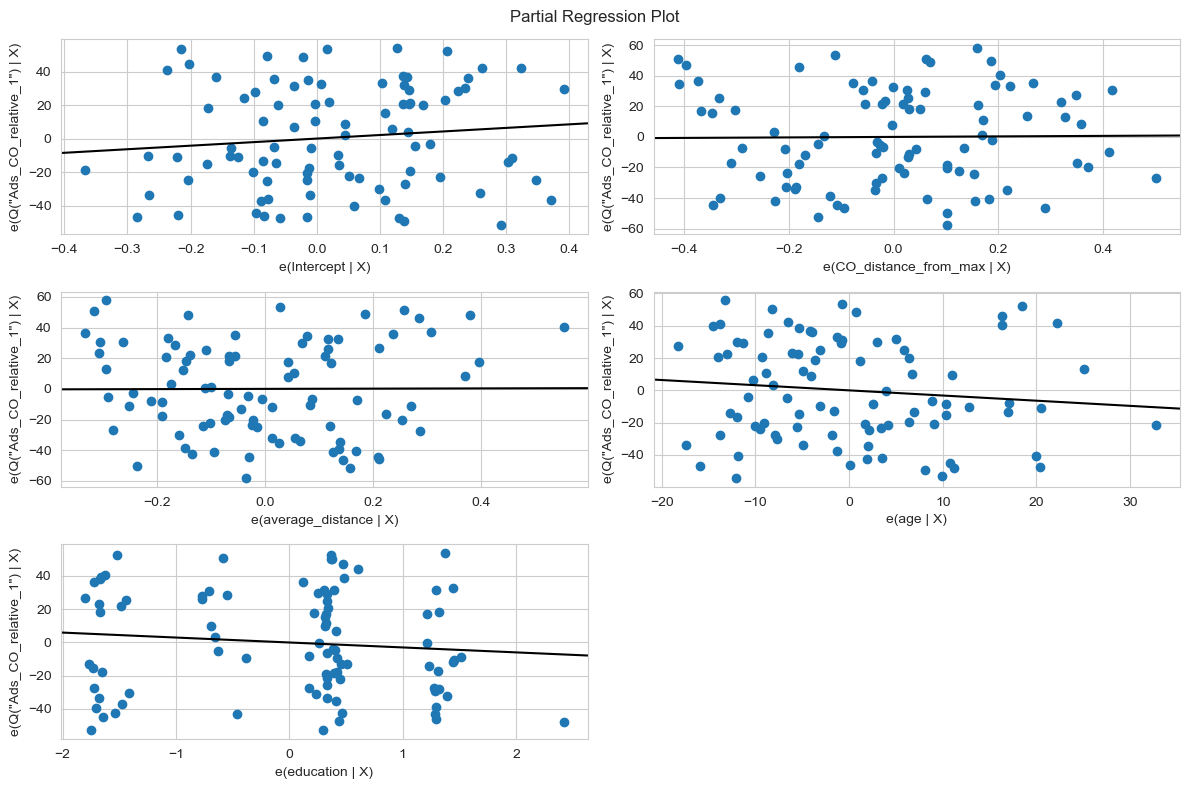

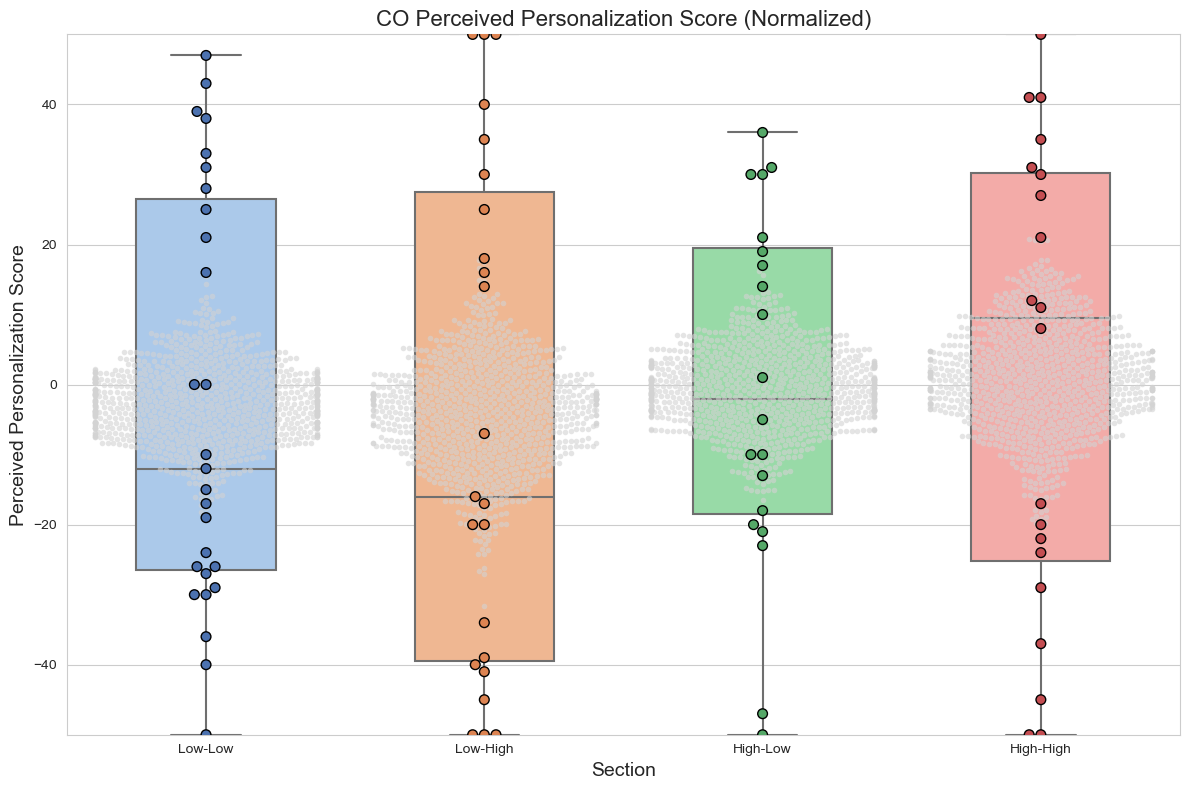


Analysis Results for AG:

Section: High-High
N: 22
Mean: 7.18
95% CI: (-3.77, 17.55)
P-value: 0.2111
Cohen's d: 0.28
Preferred Ad Type: Blended

Section: Low-High
N: 21
Mean: 9.19
95% CI: (-3.95, 21.86)
P-value: 0.1839
Cohen's d: 0.31
Preferred Ad Type: Blended

Section: Low-Low
N: 26
Mean: 8.19
95% CI: (-1.77, 17.50)
P-value: 0.1225
Cohen's d: 0.32
Preferred Ad Type: Blended

Section: High-Low
N: 21
Mean: 12.86
95% CI: (2.81, 22.57)
P-value: 0.0223
Cohen's d: 0.55
Preferred Ad Type: Blended

Linear Regression Results:
                              OLS Regression Results                              
Dep. Variable:     Q("Ads_AG_relative_1")   R-squared:                       0.034
Model:                                OLS   Adj. R-squared:                 -0.012
Method:                     Least Squares   F-statistic:                    0.7454
Date:                    Sun, 28 Jul 2024   Prob (F-statistic):              0.564
Time:                            07:51:28   Log-Likelihood:

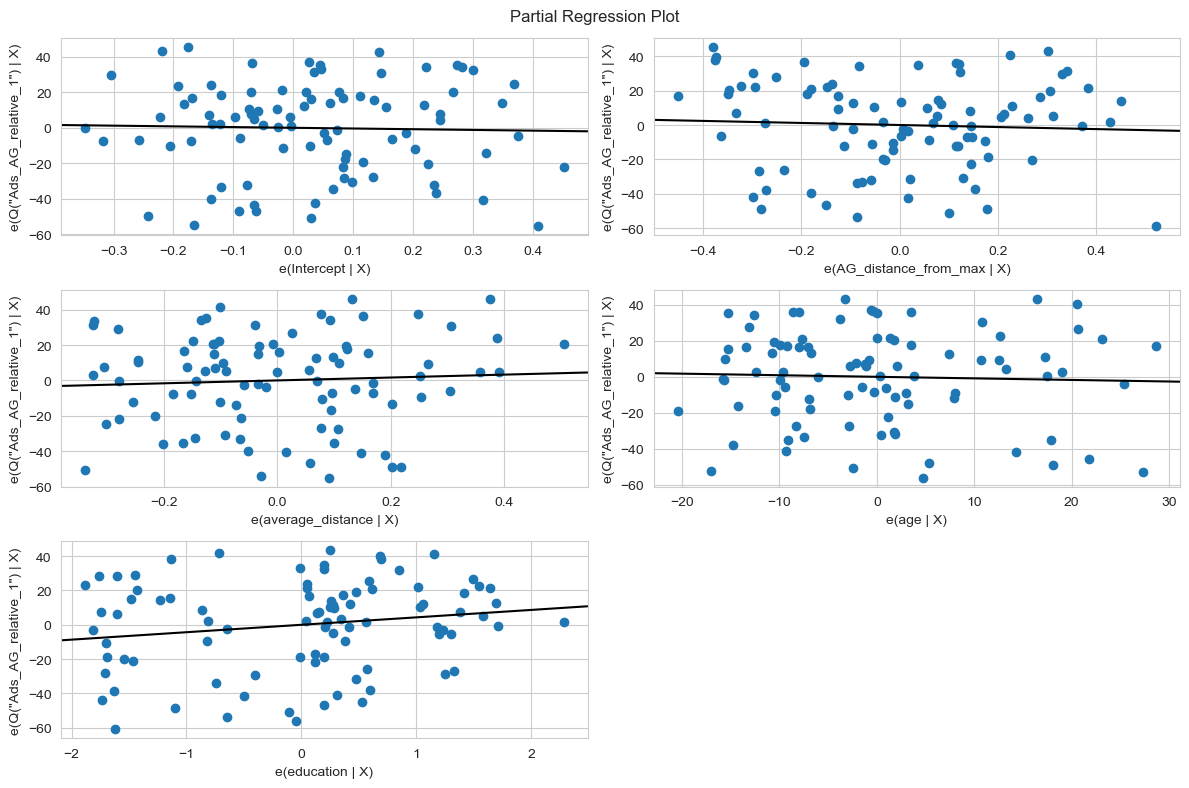

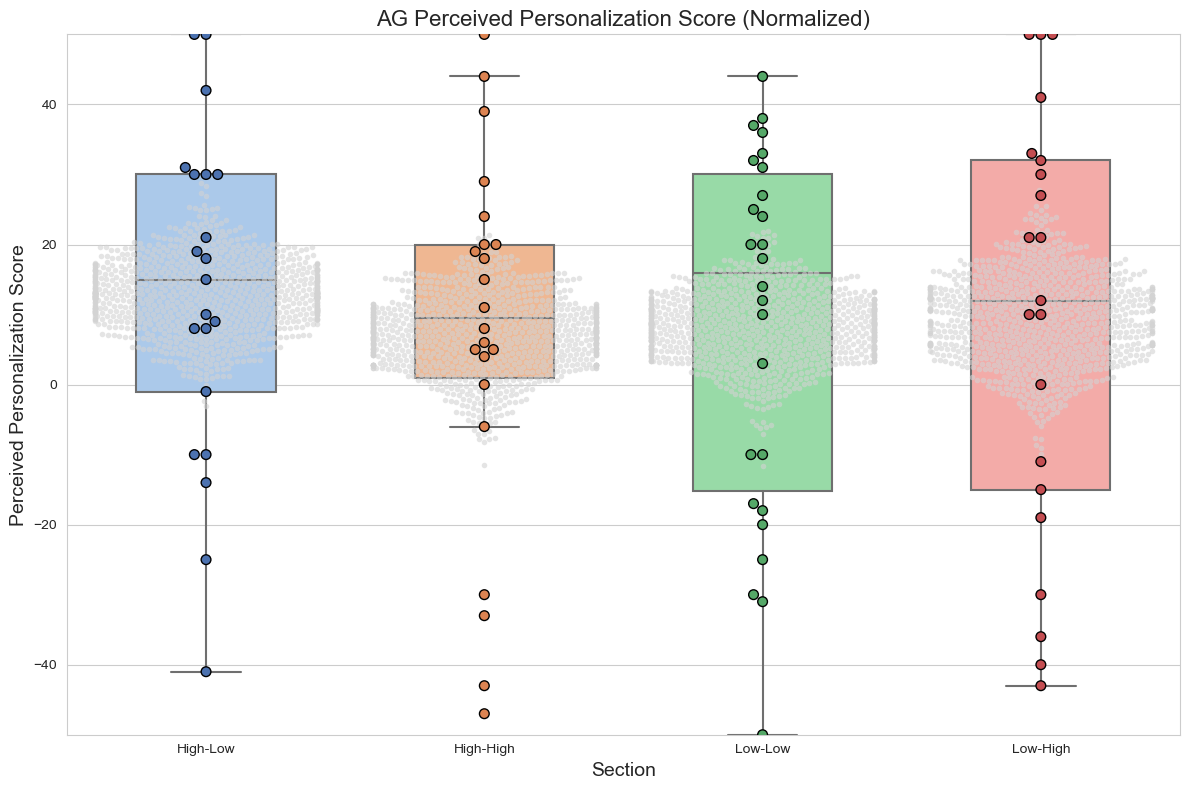

In [38]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.graphics.regressionplots import plot_partregress_grid

def analyze_trait_personalization(trait, data, n_bootstrap=10000):
    # データの準備
    analysis_data = data[[f'Ads_{trait}_relative_1', 
                          f'{trait}_distance_from_max', 
                          'average_distance',
                          'age', 'education']].copy()
    
    # セクションの作成
    x_median = analysis_data[f'{trait}_distance_from_max'].median()
    y_median = analysis_data['average_distance'].median()
    
    analysis_data['section'] = np.select(
        [
            (analysis_data[f'{trait}_distance_from_max'] > x_median) & (analysis_data['average_distance'] > y_median),
            (analysis_data[f'{trait}_distance_from_max'] <= x_median) & (analysis_data['average_distance'] > y_median),
            (analysis_data[f'{trait}_distance_from_max'] <= x_median) & (analysis_data['average_distance'] <= y_median),
            (analysis_data[f'{trait}_distance_from_max'] > x_median) & (analysis_data['average_distance'] <= y_median)
        ],
        ['High-High', 'Low-High', 'Low-Low', 'High-Low']
    )
    
    def bootstrap_analysis(scores):
        bootstrap_means = [np.mean(np.random.choice(scores, size=len(scores), replace=True)) for _ in range(n_bootstrap)]
        ci = np.percentile(bootstrap_means, [2.5, 97.5])
        t_stat, p_value = stats.ttest_1samp(scores, 0)
        cohens_d = np.mean(scores) / np.std(scores)
        return np.mean(scores), ci, p_value, cohens_d

    # 各セクションの分析
    results = []
    for section in ['High-High', 'Low-High', 'Low-Low', 'High-Low']:
        section_data = analysis_data[analysis_data['section'] == section][f'Ads_{trait}_relative_1']
        mean, ci, p_value, cohens_d = bootstrap_analysis(section_data)
        results.append({
            'Section': section,
            'N': len(section_data),
            'Mean': mean,
            'CI': ci,
            'P-value': p_value,
            "Cohens d": cohens_d,
            'Preferred': 'Blended' if mean > 0 else 'Single Trait'
        })
    
    # 結果の表示
    print(f"\nAnalysis Results for {trait}:")
    for result in results:
        print(f"\nSection: {result['Section']}")
        print(f"N: {result['N']}")
        print(f"Mean: {result['Mean']:.2f}")
        print(f"95% CI: ({result['CI'][0]:.2f}, {result['CI'][1]:.2f})")
        print(f"P-value: {result['P-value']:.4f}")
        print(f"Cohen's d: {result['Cohens d']:.2f}")
        print(f"Preferred Ad Type: {result['Preferred']}")
    
    # 線形回帰分析
    model = ols(f'Q("Ads_{trait}_relative_1") ~ {trait}_distance_from_max + average_distance + age + education', data=analysis_data).fit()
    print("\nLinear Regression Results:")
    print(model.summary())
    
    # 線形モデルの可視化
    fig = plt.figure(figsize=(12, 8))
    plot_partregress_grid(model, fig=fig)
    plt.tight_layout()
    plt.show()
    
    # スタイリッシュなボックスプロットの作成
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    # Bootstrap データの生成
    bootstrap_data = []
    for section in analysis_data['section'].unique():
        section_data = analysis_data[analysis_data['section'] == section][f'Ads_{trait}_relative_1']
        for _ in range(1000):  # 1000個のブートストラップサンプル
            bootstrap_sample = np.random.choice(section_data, size=len(section_data), replace=True)
            bootstrap_data.append({'section': section, f'Ads_{trait}_relative_1': np.mean(bootstrap_sample)})
    
    bootstrap_df = pd.DataFrame(bootstrap_data)
    
    # ボックスプロット
    sns.boxplot(x='section', y=f'Ads_{trait}_relative_1', data=analysis_data, 
                palette='pastel', width=0.5, fliersize=0)
    
    # Bootstrap データポイント
    sns.swarmplot(x='section', y=f'Ads_{trait}_relative_1', data=bootstrap_df, 
                  color='lightgray', alpha=0.6, size=4)
    
    # オリジナルデータポイント
    sns.swarmplot(x='section', y=f'Ads_{trait}_relative_1', data=analysis_data, 
                  palette='deep', size=7, edgecolor='black', linewidth=1)
    
    plt.title(f'{trait} Perceived Personalization Score (Normalized)', fontsize=16)
    plt.xlabel('Section', fontsize=14)
    plt.ylabel('Perceived Personalization Score', fontsize=14)
    plt.ylim(-50, 50)  # スコアの範囲を-50から50に設定
    
    # セクションの説明を追加
    #plt.text(0, 52, 'Section 1', ha='center', fontsize=12, color='gray')
    #plt.text(1, 52, 'Section 2', ha='center', fontsize=12, color='gray')
    #plt.text(2, 52, 'Section 3', ha='center', fontsize=12, color='gray')
    #plt.text(3, 52, 'Section 4', ha='center', fontsize=12, color='gray')
    
    plt.tight_layout()
    plt.show()

# 各特性に対して分析を実行
for trait in ['EX', 'OP', 'CO', 'AG']:
    analyze_trait_personalization(trait, merged_df_norm)

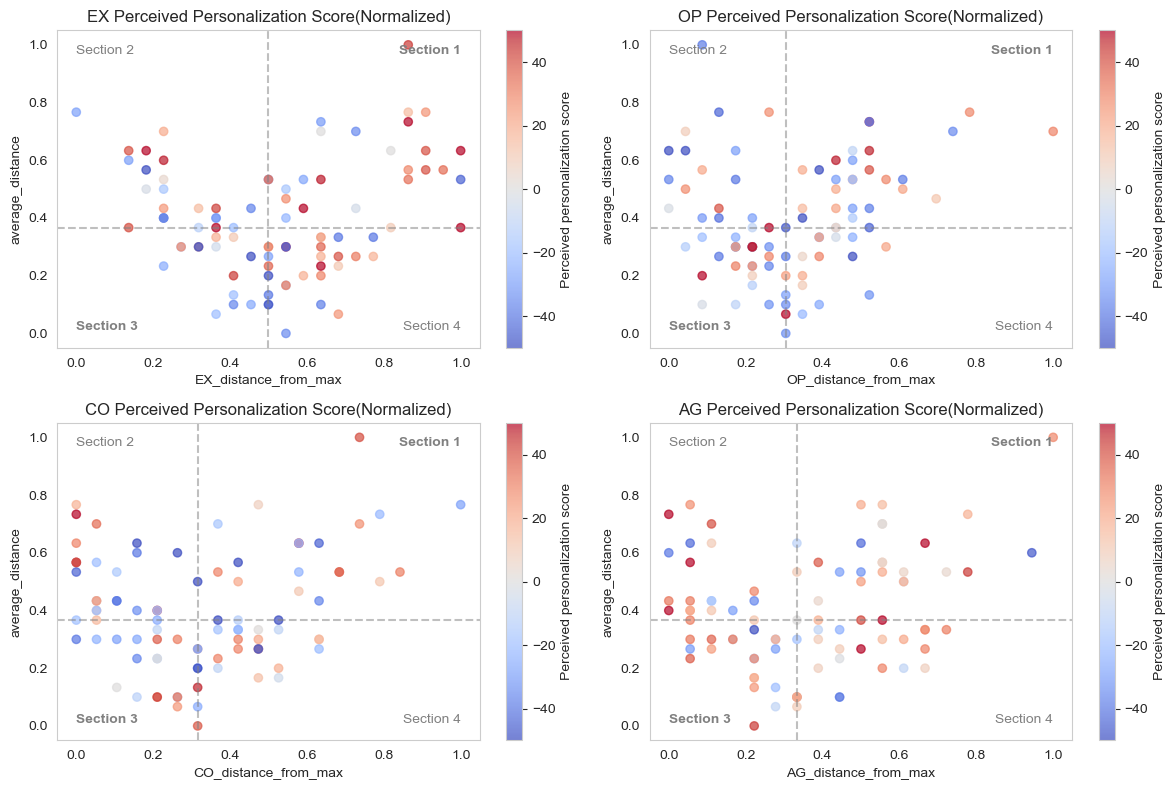

 Section Trait  N   Mean   Preference              CI  t-statistics  p-value  Cohen's d
       1    AG 26   8.19      Blended  (-0.96, 17.62)          1.60   0.1225       0.32
       1    CO 27  -2.59 Single Trait  (-14.69, 7.98)         -0.45   0.6530      -0.09
       1    EX 26  -7.00 Single Trait  (-18.79, 5.16)         -1.10   0.2826      -0.22
       1    OP 32  -5.12 Single Trait  (-15.72, 5.16)         -0.87   0.3921      -0.16
       3    AG 21   9.19      Blended  (-2.45, 22.57)          1.38   0.1839       0.31
       3    CO 23  -4.39 Single Trait (-19.00, 11.37)         -0.58   0.5682      -0.12
       3    EX 20  -3.10 Single Trait (-20.80, 10.18)         -0.40   0.6938      -0.09
       3    OP 16 -16.88 Single Trait (-26.92, -2.23)         -2.12   0.0507      -0.55


In [39]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

def analyze_trait_bootstrap(traits, data, scaled="", n_bootstrap=10000):
    all_results = []
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()

    for idx, trait in enumerate(traits):
        x = data[f'{trait}_distance_from_max']
        y = data['average_distance']
        z = data[f'Ads_{trait}_relative_1']
        x_median = np.median(x)
        y_median = np.median(y)

        # 散布図
        scatter = axs[idx].scatter(x, y, c=z, cmap='coolwarm', alpha=0.7)
        axs[idx].grid(False)
        
        # セクション分割線の追加
        axs[idx].axvline(x_median, color='grey', linestyle='--', alpha=0.5)
        axs[idx].axhline(y_median, color='grey', linestyle='--', alpha=0.5)
        axs[idx].set_xlabel(f'{trait}_distance_from_max')
        axs[idx].set_ylabel('average_distance')
        axs[idx].set_title(f'{trait} Perceived Personalization Score{scaled}')
        plt.colorbar(scatter, ax=axs[idx], label='Perceived personalization score')

        # セクションの注釈を追加
        axs[idx].text(x.min(), y.max(), 'Section 2', ha='left', va='top', color='grey')
        axs[idx].text(x.max(), y.max(), 'Section 1', ha='right', va='top', color='grey', weight='bold')
        axs[idx].text(x.min(), y.min(), 'Section 3', ha='left', va='bottom', color='grey', weight='bold')
        axs[idx].text(x.max(), y.min(), 'Section 4', ha='right', va='bottom', color='grey')

        # セクションの定義と分析
        data['section'] = 2 * (y > y_median) + (x > x_median) + 1

        def bootstrap_analysis(scores):
            bootstrap_means = [np.mean(resample(scores, n_samples=len(scores))) for _ in range(n_bootstrap)]
            mean = np.mean(scores)
            ci = np.round(np.percentile(bootstrap_means, [2.5, 97.5]), 2)
            t_stat, p_value = stats.ttest_1samp(scores, 0)
            cohens_d = mean / np.std(scores)
            return mean, ci, t_stat, p_value, cohens_d

        for section in [1, 3]:  # Analyze sections 1 (high-high) and 3 (low-low)
            section_data = data[data['section'] == section][f'Ads_{trait}_relative_1']
            mean, ci, t_stat, p_value, cohens_d = bootstrap_analysis(section_data)
            all_results.append({
                'Section': section,
                'Trait': trait,
                'N': len(section_data),
                'Mean': mean,
                'Preference': 'Blended' if mean > 0 else 'Single Trait',
                'CI': f"({ci[0]:.2f}, {ci[1]:.2f})",
                't-statistics': t_stat,
                'p-value': p_value,
                "Cohen's d": cohens_d
            })

    plt.tight_layout()
    plt.show()

    # 結果テーブルの作成と表示
    results_df = pd.DataFrame(all_results)
    results_df = results_df[['Section', 'Trait', 'N', 'Mean', 'Preference', 'CI', 't-statistics', 'p-value', "Cohen's d"]]
    results_df = results_df.sort_values(['Section', 'Trait'])
    results_df = results_df.round({'Mean': 2, 't-statistics': 2, 'p-value': 4, "Cohen's d": 2})
    print(results_df.to_string(index=False))

# 分析の実行
traits = ['EX', 'OP', 'CO', 'AG']
analyze_trait_bootstrap(traits, 
                        merged_df_norm, 
                        scaled="(Normalized)",
                        n_bootstrap=100)

Section Preference Analysis:
 Section Trait  N  Preference Rate  Binomial Test p-value
       1    AG 26           0.6538                 0.1686
       1    CO 27           0.3704                 0.2478
       1    EX 26           0.3846                 0.3269
       1    OP 32           0.3750                 0.2153
       2    AG 21           0.7143                 0.0784
       2    CO 20           0.5000                 1.0000
       2    EX 21           0.7143                 0.0784
       2    OP 15           0.4667                 1.0000
       3    AG 21           0.6190                 0.3833
       3    CO 23           0.4348                 0.6776
       3    EX 20           0.4500                 0.8238
       3    OP 16           0.3125                 0.2101
       4    AG 22           0.7273                 0.0525
       4    CO 20           0.5500                 0.8238
       4    EX 23           0.6087                 0.4049
       4    OP 27           0.5185         

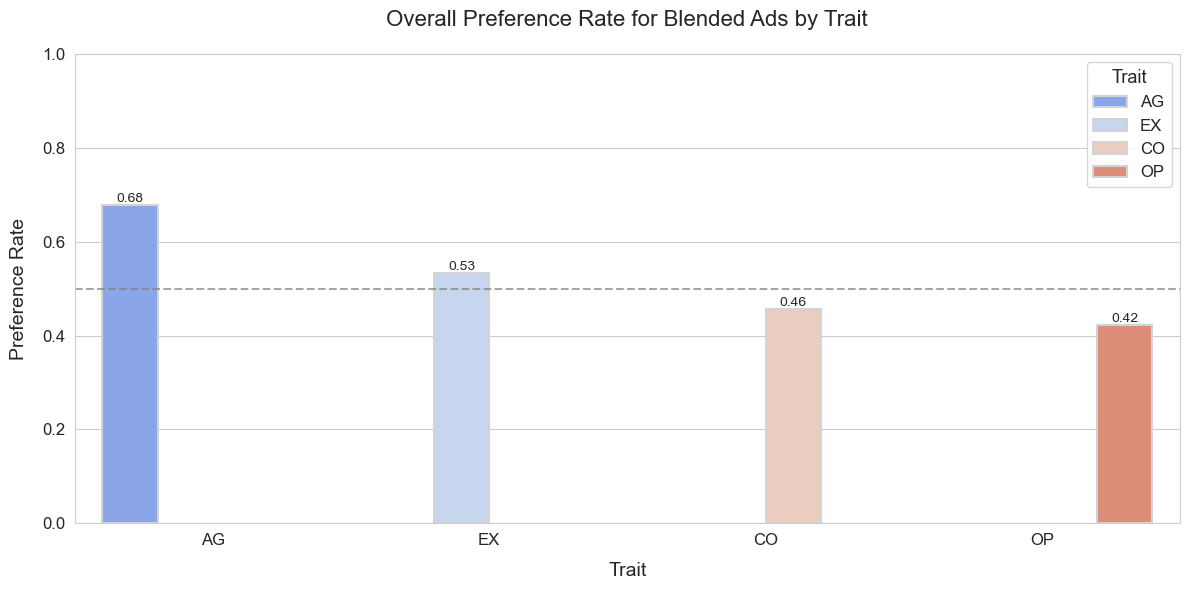

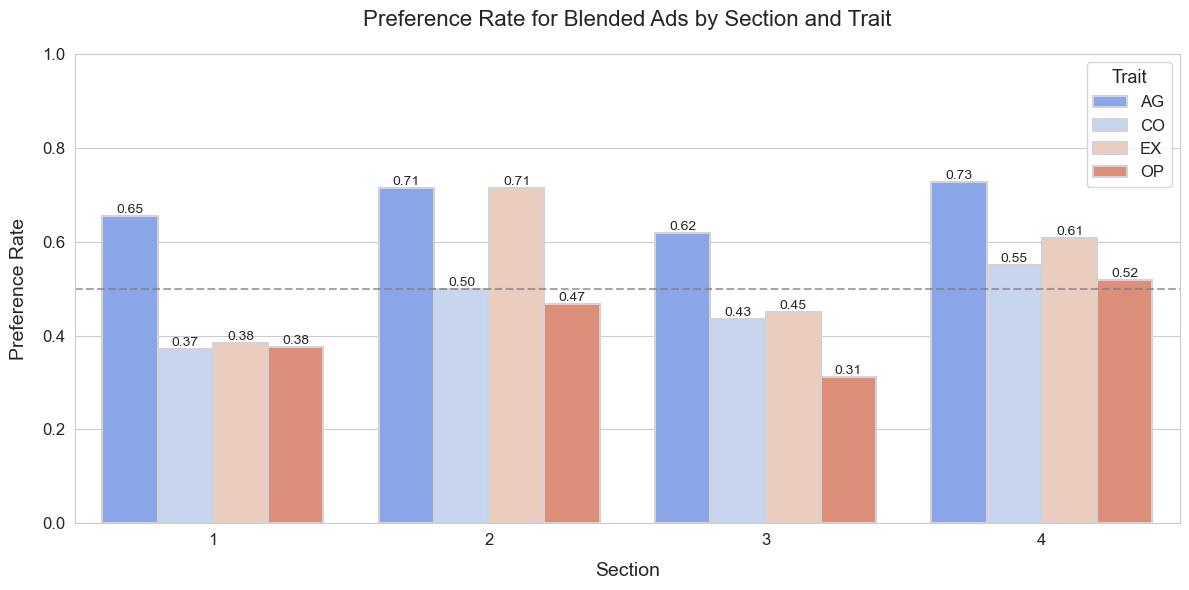

In [70]:
def analyze_trait_bootstrap(traits, data, scaled="", n_bootstrap=10000):
    section_preferences = []
    overall_preference = []

    for trait in traits:
        x = data[f'{trait}_distance_from_max']
        y = data['average_distance']
        z = data[f'Ads_{trait}_relative_1']
        x_median = np.median(x)
        y_median = np.median(y)

        # セクションの定義
        data['section'] = 2 * (y > y_median) + (x > x_median) + 1

        for section in [1, 2, 3, 4]:
            section_data = data[data['section'] == section][f'Ads_{trait}_relative_1']
            preference_rate = np.mean(section_data > 0)
            n_section = len(section_data)
            binom_p_value = stats.binom_test(int(preference_rate * n_section), n_section, p=0.5)
            
            section_preferences.append({
                'Section': section,
                'Trait': trait,
                'N': n_section,
                'Preference Rate': preference_rate,
                'Binomial Test p-value': binom_p_value
            })

        # Calculate overall preference
        trait_data = data[f'Ads_{trait}_relative_1']
        preference_rate = np.mean(trait_data > 0)
        binom_p_value = stats.binom_test(int(preference_rate * len(trait_data)), len(trait_data), p=0.5)
        overall_preference.append({
            'Trait': trait,
            'Preference Rate': preference_rate,
            'Binomial Test p-value': binom_p_value
        })

    # Create dataframes
    section_pref_df = pd.DataFrame(section_preferences)
    section_pref_df = section_pref_df.sort_values(['Section', 'Trait'])
    section_pref_df = section_pref_df.round({'Preference Rate': 4, 'Binomial Test p-value': 4})

    overall_pref_df = pd.DataFrame(overall_preference)
    overall_pref_df = overall_pref_df.sort_values('Preference Rate', ascending=False)
    overall_pref_df = overall_pref_df.round({'Preference Rate': 4, 'Binomial Test p-value': 4})

    # Print results
    print("Section Preference Analysis:")
    print(section_pref_df.to_string(index=False))
    print("\nOverall Preference for Blended Ads:")
    print(overall_pref_df.to_string(index=False))

    # Visualization function
    def plot_preference_rates(data, title, x_label):
        plt.figure(figsize=(12, 6))
        sns.set_style("whitegrid")
        bar_plot = sns.barplot(x=x_label, y='Preference Rate', hue='Trait', data=data, 
                               palette='coolwarm', edgecolor='lightgrey', linewidth=1.5)
        
        plt.title(title, fontsize=16, pad=20)
        plt.xlabel(x_label, fontsize=14, labelpad=10)
        plt.ylabel('Preference Rate', fontsize=14, labelpad=10)
        plt.ylim(0, 1)
        plt.axhline(0.5, color='gray', linestyle='--', alpha=0.7)
        
        for container in bar_plot.containers:
            bar_plot.bar_label(container, fmt='%.2f', label_type='edge')
        
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(title='Trait', title_fontsize='13', fontsize='12')
        plt.gca().set_facecolor('white')
        
        plt.tight_layout()
        plt.show()

    # Visualize overall preference
    plot_preference_rates(overall_pref_df, 'Overall Preference Rate for Blended Ads by Trait', 'Trait')

    # Visualize section preference
    plot_preference_rates(section_pref_df, 'Preference Rate for Blended Ads by Section and Trait', 'Section')

# 分析の実行
traits = ['EX', 'OP', 'CO', 'AG']
analyze_trait_bootstrap(traits, merged_df_norm, scaled="(Normalized)", n_bootstrap=10000)

In [41]:
def analyze_controlled_cdf_robust(data, traits=['EX', 'OP', 'CO', 'AG'], 
                                  n_groups=2, n_bootstrap=1000):
    results = []
    for trait in traits:
        print(f"\n{'-'*50}\nRobust Controlled CDF Analysis for {trait}\n{'-'*50}")
        
        # Create distance groups (coarser segmentation)
        data['trait_distance_group'] = pd.qcut(data[f'{trait}_distance_from_max'], 
                                               q=n_groups, 
                                               labels=['Low', 'High'])
        data['avg_distance_group'] = pd.qcut(data['average_distance'], 
                                             q=n_groups, 
                                             labels=['Low', 'High'])
        
        for trait_group in ['Low', 'High']:
            for avg_group in ['Low', 'High']:
                subset = data[(data['trait_distance_group'] == trait_group) & 
                              (data['avg_distance_group'] == avg_group)]
                
                scores = subset[f'Ads_{trait}_relative_1']
                
                print(f"\nGroup: Trait Distance {trait_group}, Avg Distance {avg_group}")
                print(f"Sample size: {len(subset)}")
                
                if len(scores) > 0:
                    # Bootstrap analysis
                    boot_means = []
                    boot_prefs = []
                    for _ in range(n_bootstrap):
                        boot_scores = resample(scores, n_samples=len(scores))
                        boot_means.append(np.mean(boot_scores))
                        boot_prefs.append(np.sum(boot_scores > 0) / len(boot_scores))
                    
                    # Results
                    mean_score = np.mean(scores)
                    ci_score = np.percentile(boot_means, [2.5, 97.5])
                    blended_pref = np.mean(boot_prefs)
                    blended_pref_ci = np.percentile(boot_prefs, [2.5, 97.5])
                    
                    # T-test
                    t_stat, p_value = stats.ttest_1samp(scores, 0)
                    
                    print(f"Mean score: {mean_score:.4f}")
                    print(f"95% CI: ({ci_score[0]:.4f}, {ci_score[1]:.4f})")
                    print(f"T-statistic: {t_stat:.4f}")
                    print(f"p-value: {p_value:.4f}")
                    print(f"Blended preference: {blended_pref:.2%} (95% CI: {blended_pref_ci[0]:.2%}, {blended_pref_ci[1]:.2%})")
                    
                    results.append({
                        'Trait': trait,
                        'Trait Distance': trait_group,
                        'Avg Distance': avg_group,
                        'N': len(scores),
                        'Mean Score': mean_score,
                        'CI Lower': ci_score[0],
                        'CI Upper': ci_score[1],
                        'T-statistic': t_stat,
                        'P-value': p_value,
                        'Blended Preference': blended_pref,
                        'Blended Pref CI Lower': blended_pref_ci[0],
                        'Blended Pref CI Upper': blended_pref_ci[1]
                    })
                    
                    # Plot histogram
                    plt.figure(figsize=(10, 6))
                    sns.histplot(scores, kde=True)
                    plt.axvline(0, color='r', linestyle='--')
                    plt.xlabel('Perceived Personalization Score')
                    plt.ylabel('Frequency')
                    plt.title(f'Distribution for {trait}: Trait Dist {trait_group}, Avg Dist {avg_group}')
                    plt.show()
                else:
                    print("Not enough data for comparison in this group.")
    
    # Create and display results table
    results_df = pd.DataFrame(results)
    print("\nOverall Results:")
    print(results_df.to_string(index=False))
    
    return results_df


--------------------------------------------------
Analysis for EX
--------------------------------------------------


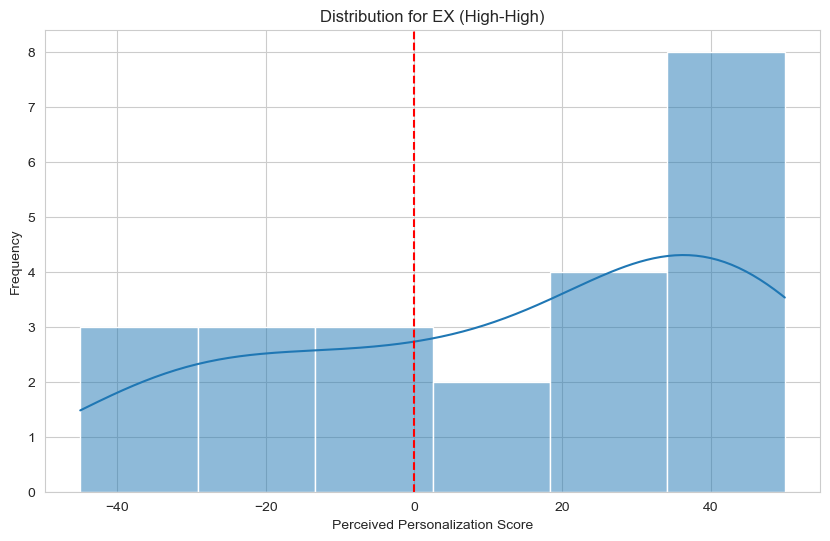

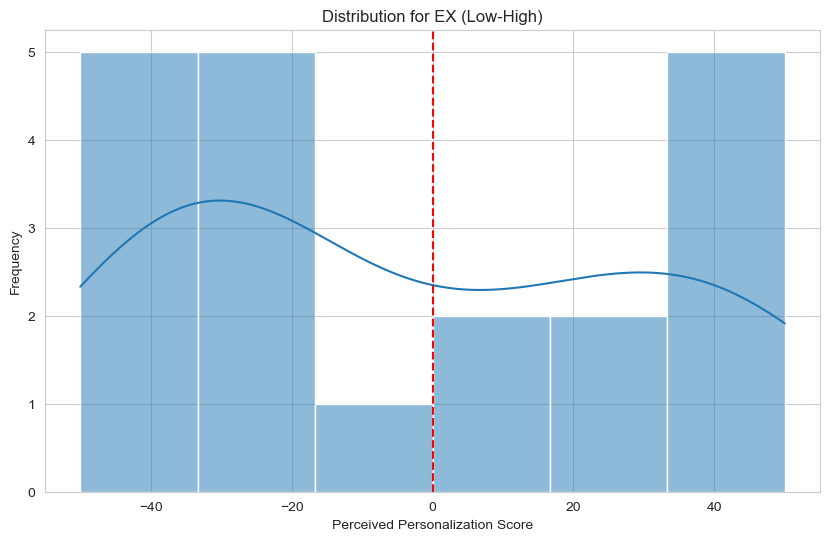

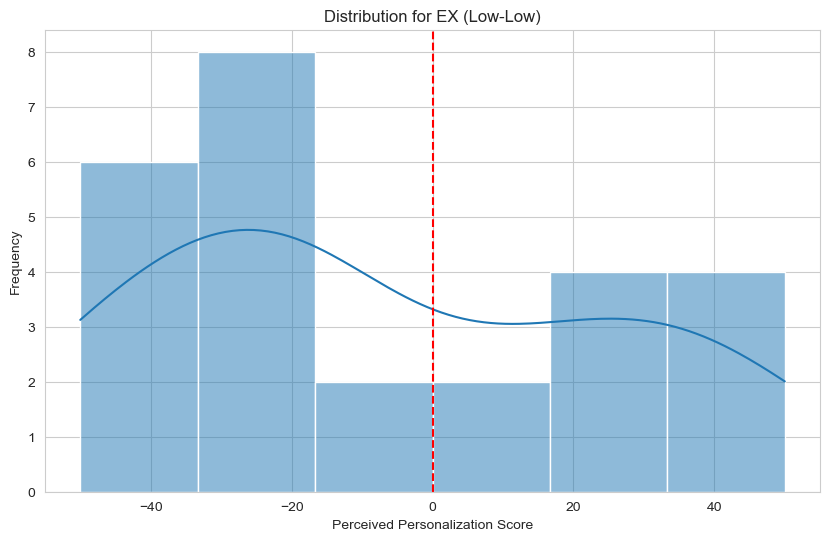

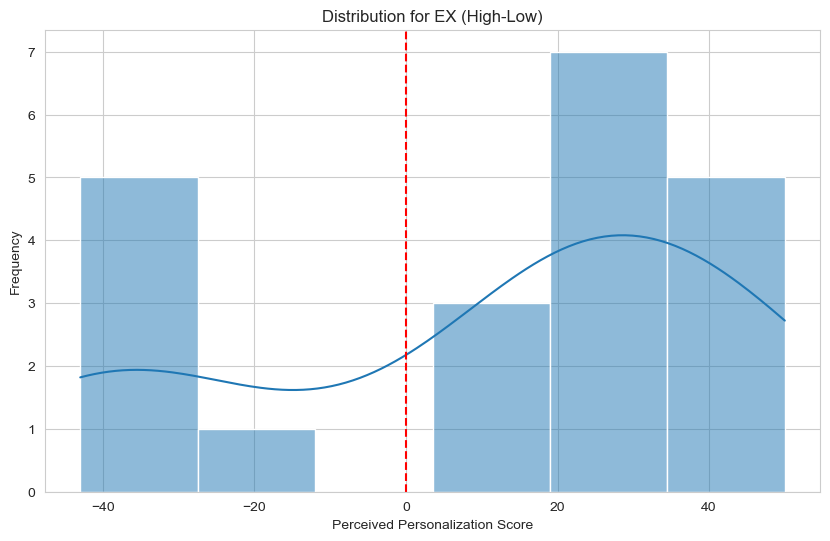


--------------------------------------------------
Analysis for OP
--------------------------------------------------


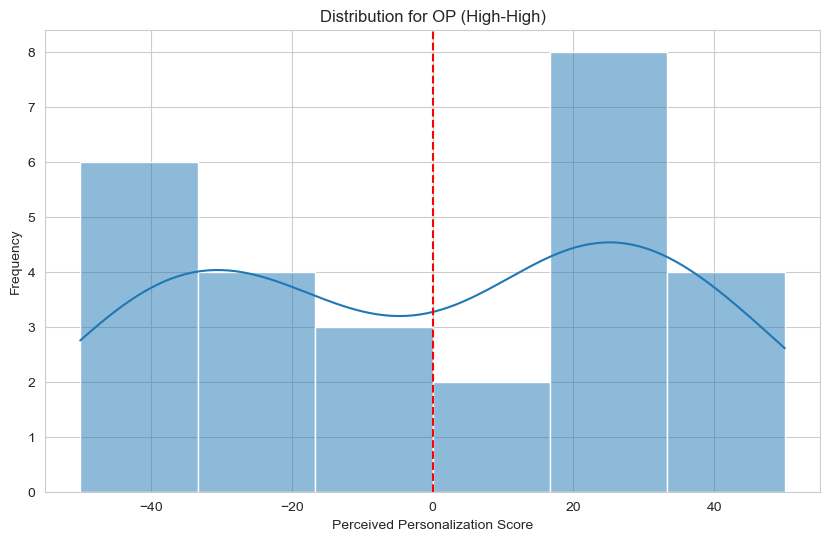

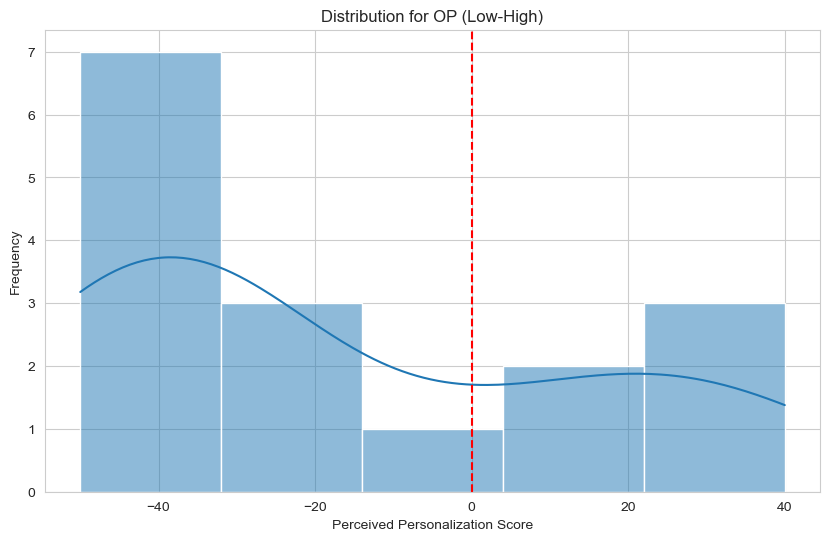

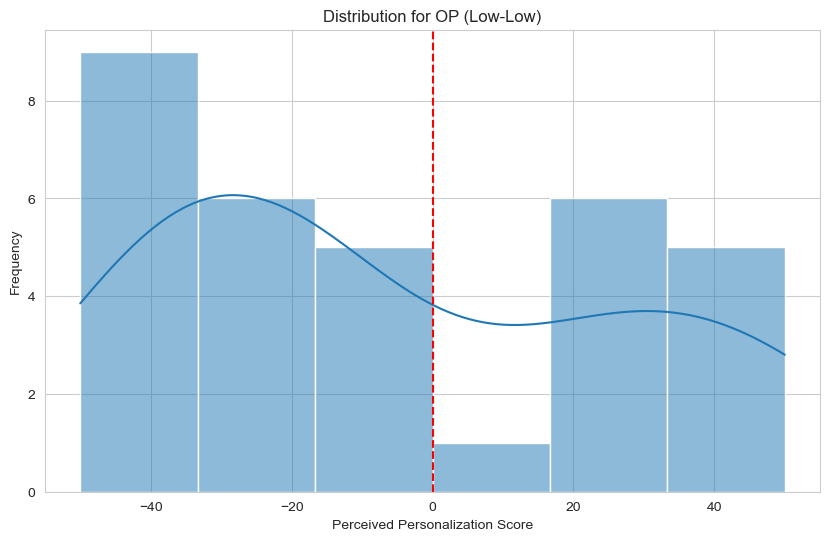

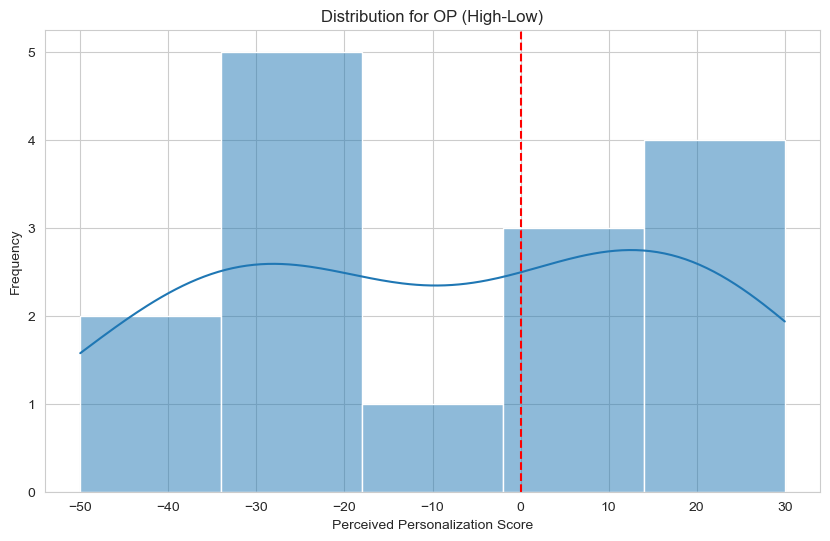


--------------------------------------------------
Analysis for CO
--------------------------------------------------


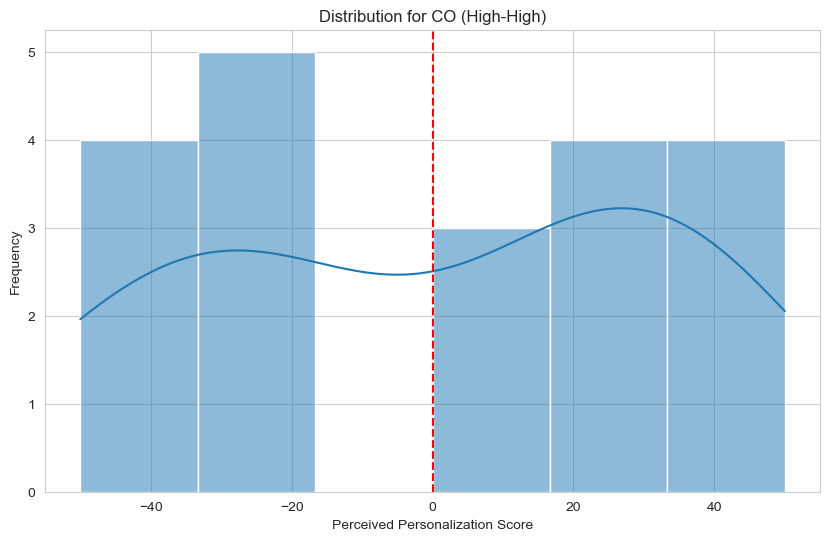

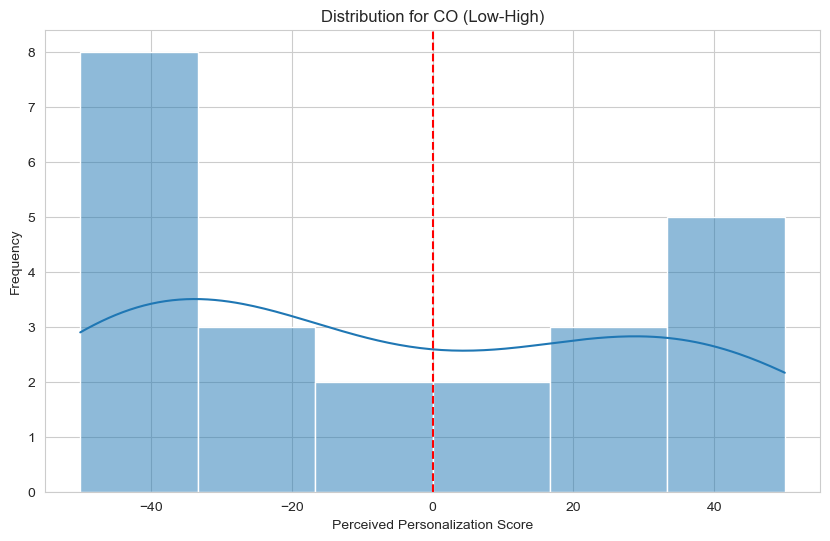

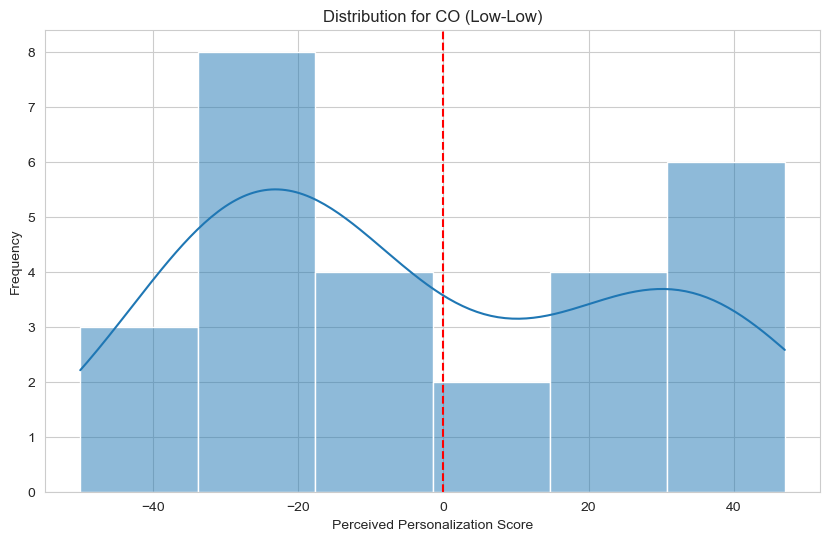

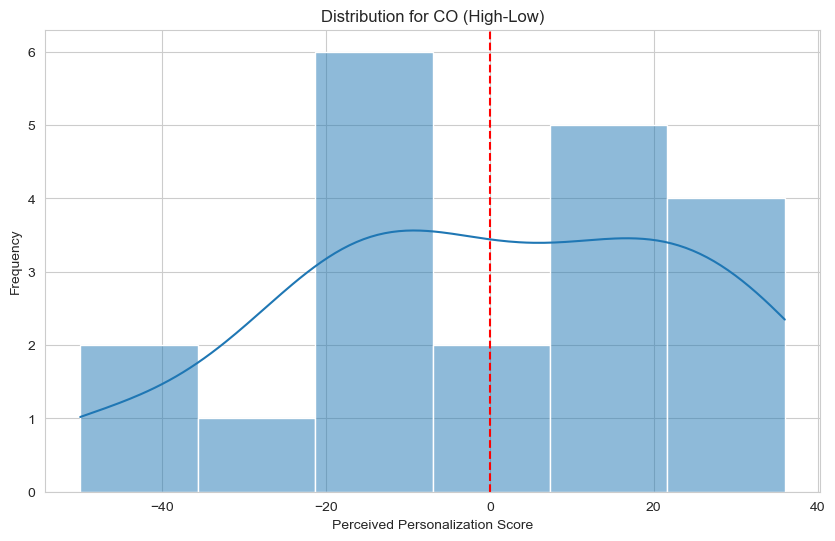


--------------------------------------------------
Analysis for AG
--------------------------------------------------


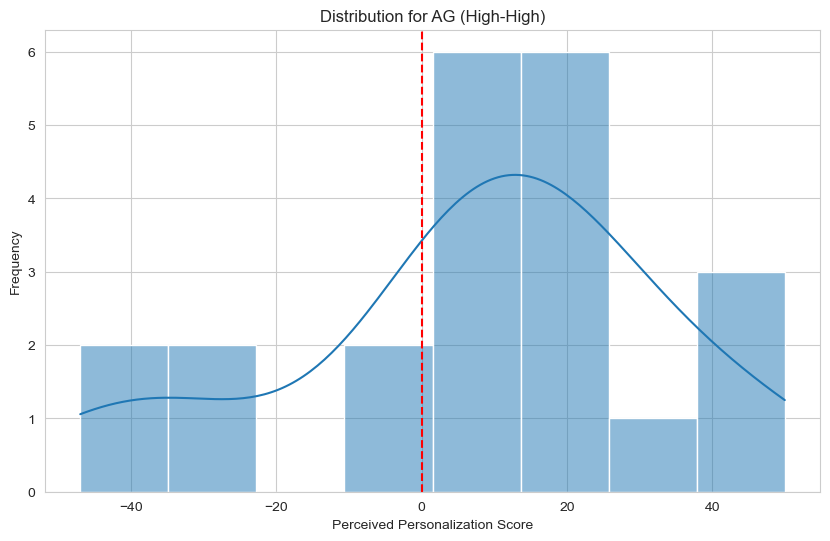

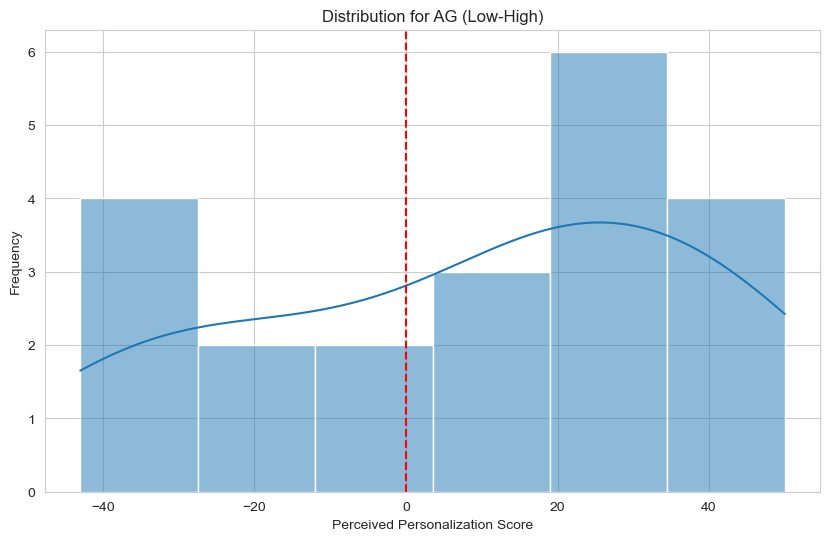

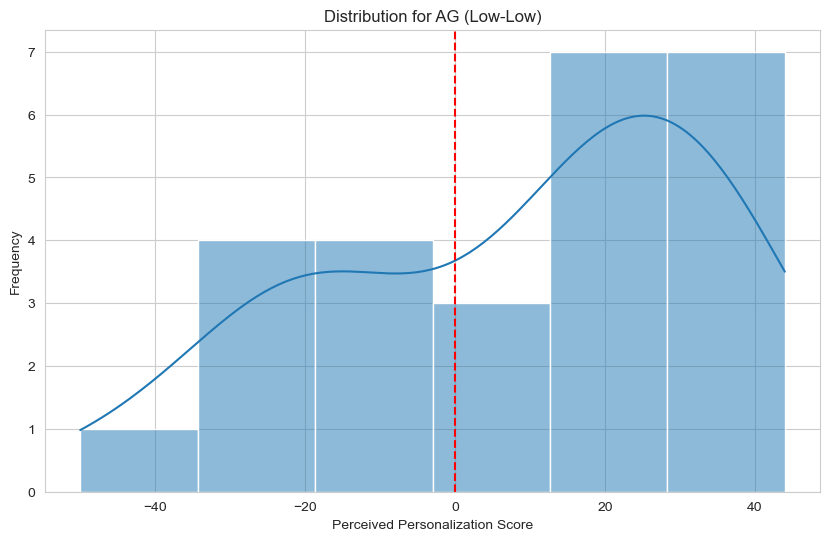

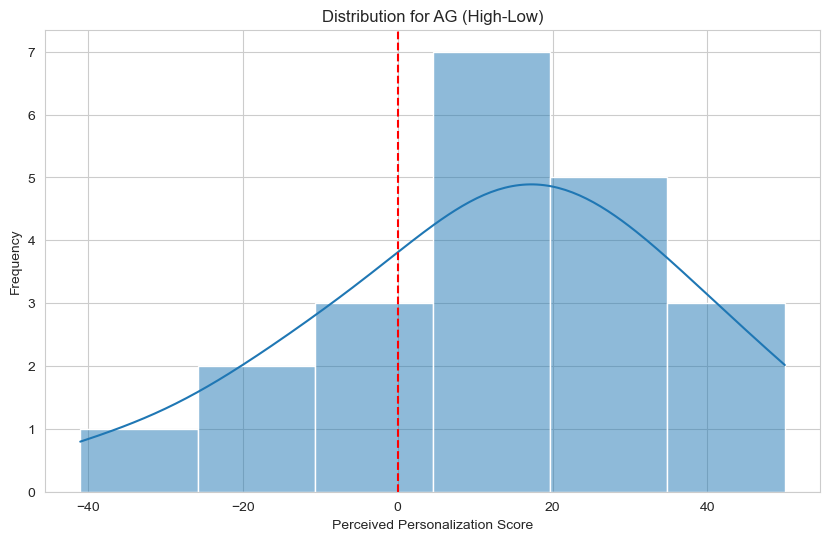

   Trait    Section   N  Mean_Score  Median_Score    Std_Dev  \
0     EX  High-High  23   13.739130          26.0  30.527560   
1     EX   Low-High  20   -3.100000         -10.0  33.802219   
2     EX    Low-Low  26   -7.000000         -19.5  31.868721   
3     EX   High-Low  21   10.904762          19.0  31.853690   
4     OP  High-High  27    0.407407          12.0  32.227501   
5     OP   Low-High  16  -16.875000         -31.0  30.773111   
6     OP    Low-Low  32   -5.125000         -13.5  32.879277   
7     OP   High-Low  15   -8.133333          -4.0  25.741967   
8     CO  High-High  20    0.650000           9.5  32.728084   
9     CO   Low-High  23   -4.391304         -16.0  35.545120   
10    CO    Low-Low  27   -2.592593         -12.0  29.066029   
11    CO   High-Low  20   -0.400000          -2.0  24.737421   
12    AG  High-High  22    7.181818           9.5  25.512272   
13    AG   Low-High  21    9.190476          12.0  29.862573   
14    AG    Low-Low  26    8.192308     

In [56]:
effectiveness_results = analyze_ad_effectiveness_range(merged_df_norm)
print(effectiveness_results)


--------------------------------------------------
Robust Controlled CDF Analysis for EX
--------------------------------------------------

Group: Trait Distance Low, Avg Distance Low
Sample size: 26
Mean score: -7.0000
95% CI: (-18.7702, 5.0394)
T-statistic: -1.0983
p-value: 0.2826
Blended preference: 38.75% (95% CI: 19.23%, 57.69%)


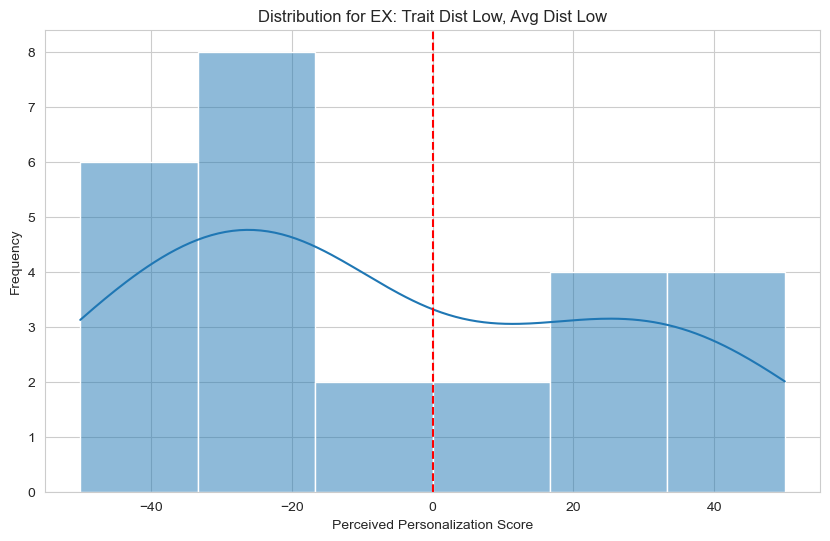


Group: Trait Distance Low, Avg Distance High
Sample size: 20
Mean score: -3.1000
95% CI: (-17.3012, 11.6012)
T-statistic: -0.3998
p-value: 0.6938
Blended preference: 44.99% (95% CI: 25.00%, 65.00%)


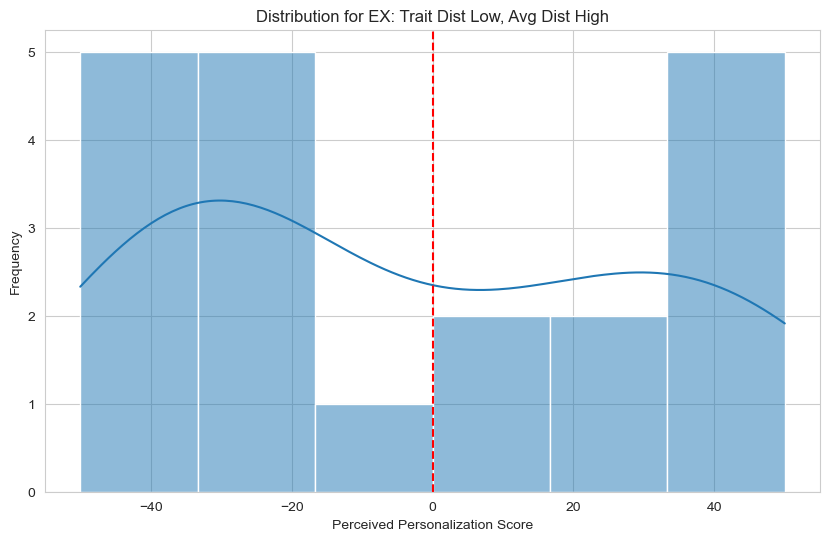


Group: Trait Distance High, Avg Distance Low
Sample size: 21
Mean score: 10.9048
95% CI: (-3.6667, 23.4286)
T-statistic: 1.5310
p-value: 0.1414
Blended preference: 70.87% (95% CI: 52.38%, 85.71%)


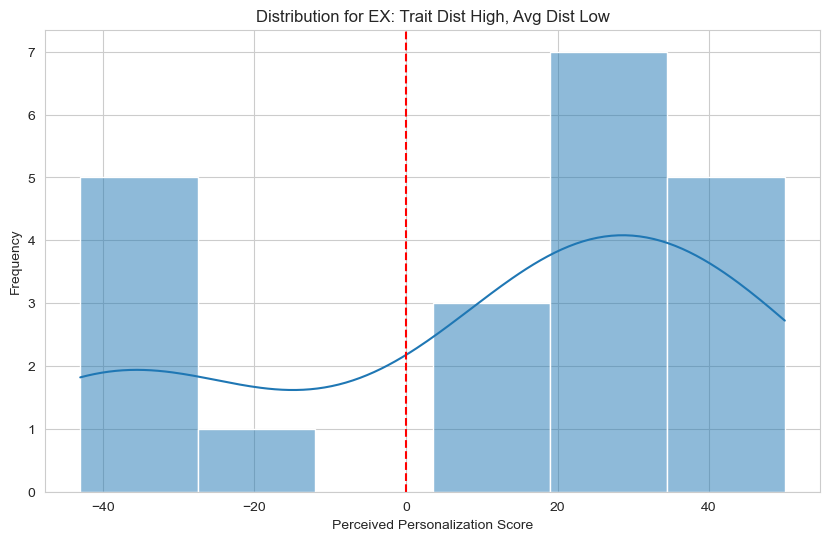


Group: Trait Distance High, Avg Distance High
Sample size: 23
Mean score: 13.7391
95% CI: (0.4761, 25.3924)
T-statistic: 2.1110
p-value: 0.0464
Blended preference: 60.87% (95% CI: 39.13%, 78.26%)


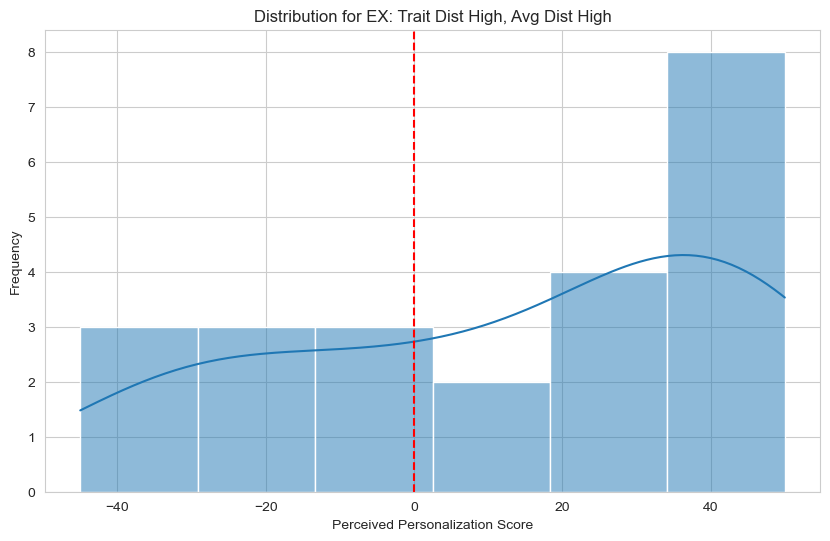


--------------------------------------------------
Robust Controlled CDF Analysis for OP
--------------------------------------------------

Group: Trait Distance Low, Avg Distance Low
Sample size: 32
Mean score: -5.1250
95% CI: (-16.4477, 6.7008)
T-statistic: -0.8679
p-value: 0.3921
Blended preference: 37.38% (95% CI: 21.88%, 56.25%)


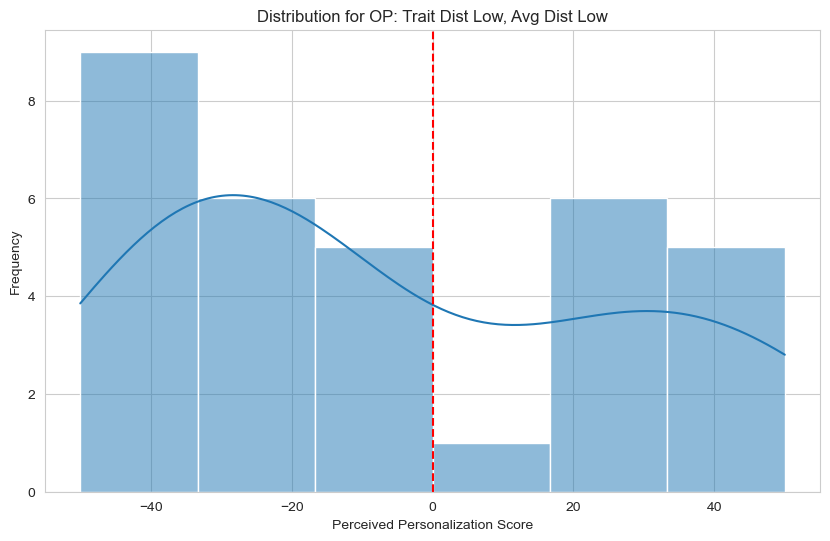


Group: Trait Distance Low, Avg Distance High
Sample size: 16
Mean score: -16.8750
95% CI: (-30.1906, -1.3719)
T-statistic: -2.1238
p-value: 0.0507
Blended preference: 31.23% (95% CI: 12.50%, 56.25%)


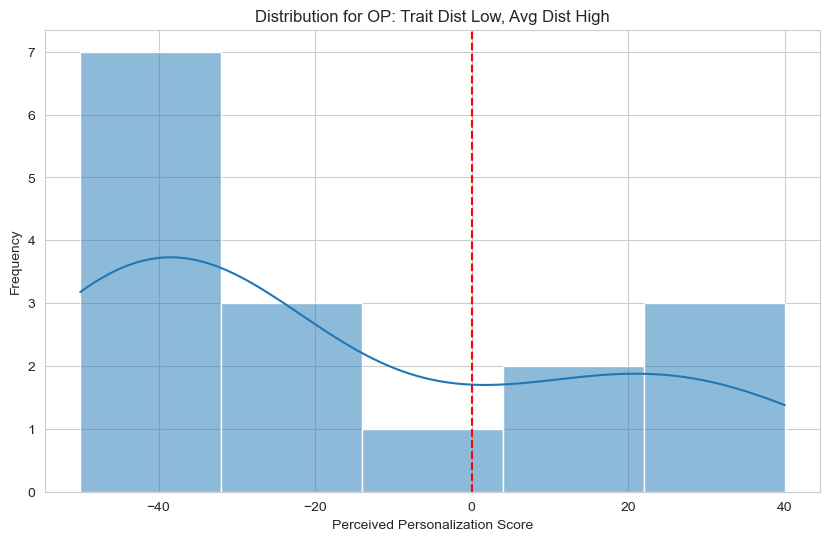


Group: Trait Distance High, Avg Distance Low
Sample size: 15
Mean score: -8.1333
95% CI: (-20.8683, 4.2667)
T-statistic: -1.1822
p-value: 0.2568
Blended preference: 46.36% (95% CI: 20.00%, 73.33%)


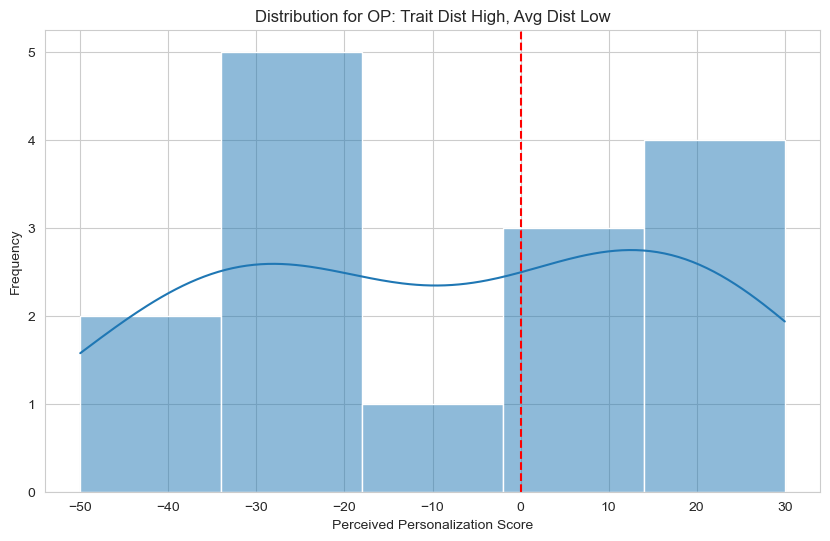


Group: Trait Distance High, Avg Distance High
Sample size: 27
Mean score: 0.4074
95% CI: (-11.4843, 13.1120)
T-statistic: 0.0645
p-value: 0.9491
Blended preference: 51.86% (95% CI: 33.33%, 70.37%)


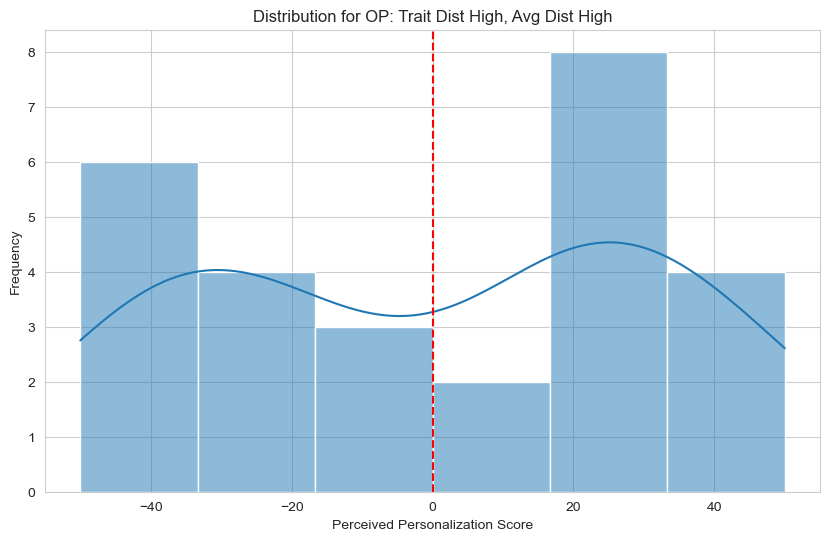


--------------------------------------------------
Robust Controlled CDF Analysis for CO
--------------------------------------------------

Group: Trait Distance Low, Avg Distance Low
Sample size: 27
Mean score: -2.5926
95% CI: (-12.9648, 8.4861)
T-statistic: -0.4548
p-value: 0.6530
Blended preference: 37.03% (95% CI: 18.52%, 55.56%)


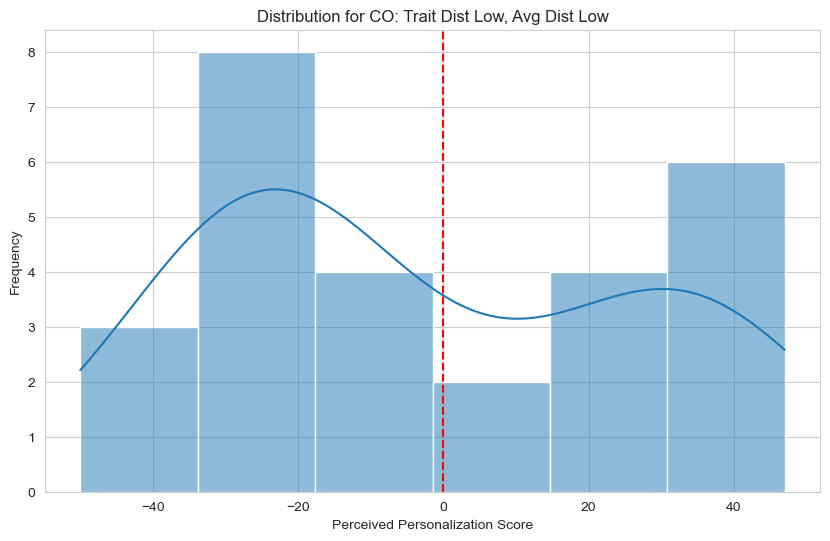


Group: Trait Distance Low, Avg Distance High
Sample size: 23
Mean score: -4.3913
95% CI: (-17.9598, 10.2630)
T-statistic: -0.5795
p-value: 0.5682
Blended preference: 43.37% (95% CI: 26.09%, 60.87%)


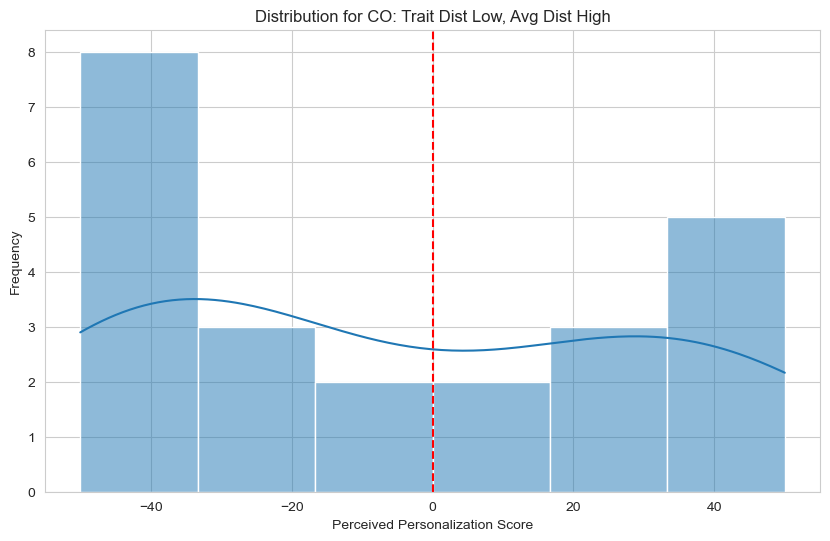


Group: Trait Distance High, Avg Distance Low
Sample size: 20
Mean score: -0.4000
95% CI: (-11.4500, 11.8012)
T-statistic: -0.0705
p-value: 0.9445
Blended preference: 50.67% (95% CI: 30.00%, 70.12%)


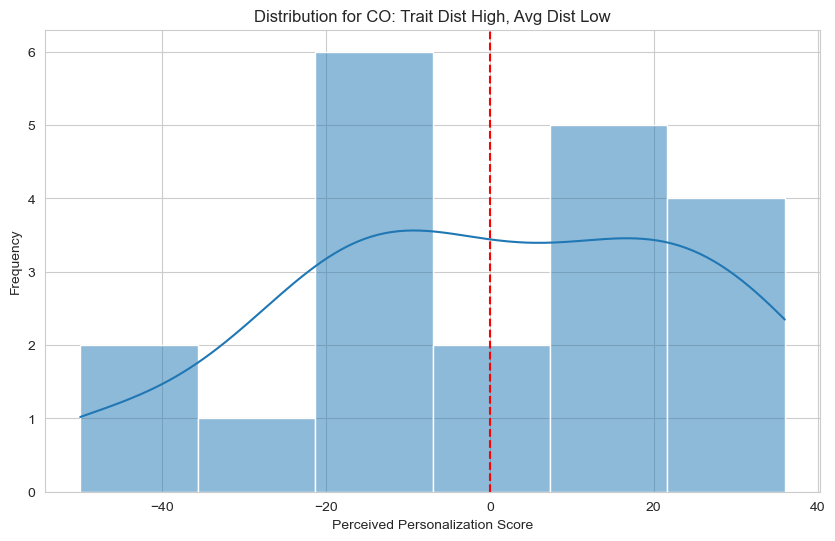


Group: Trait Distance High, Avg Distance High
Sample size: 20
Mean score: 0.6500
95% CI: (-13.0013, 14.2012)
T-statistic: 0.0866
p-value: 0.9319
Blended preference: 54.96% (95% CI: 35.00%, 75.00%)


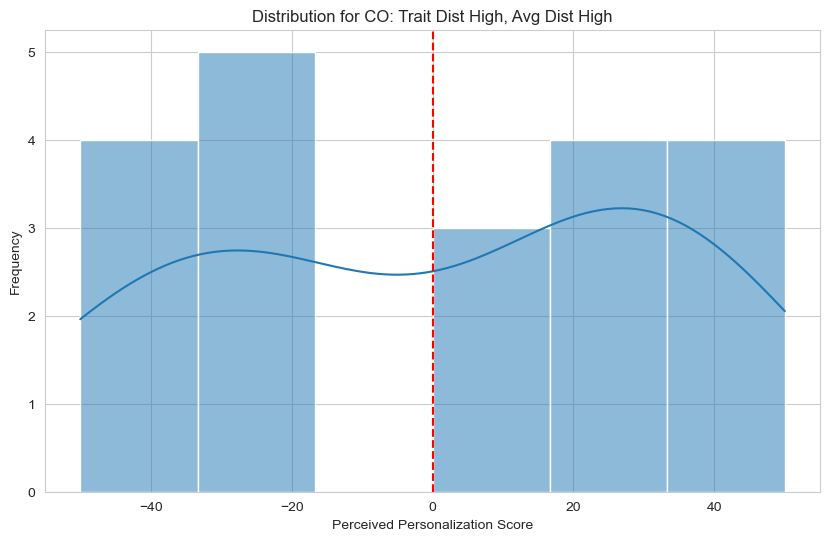


--------------------------------------------------
Robust Controlled CDF Analysis for AG
--------------------------------------------------

Group: Trait Distance Low, Avg Distance Low
Sample size: 26
Mean score: 8.1923
95% CI: (-1.8471, 17.9615)
T-statistic: 1.5983
p-value: 0.1225
Blended preference: 65.73% (95% CI: 46.15%, 84.62%)


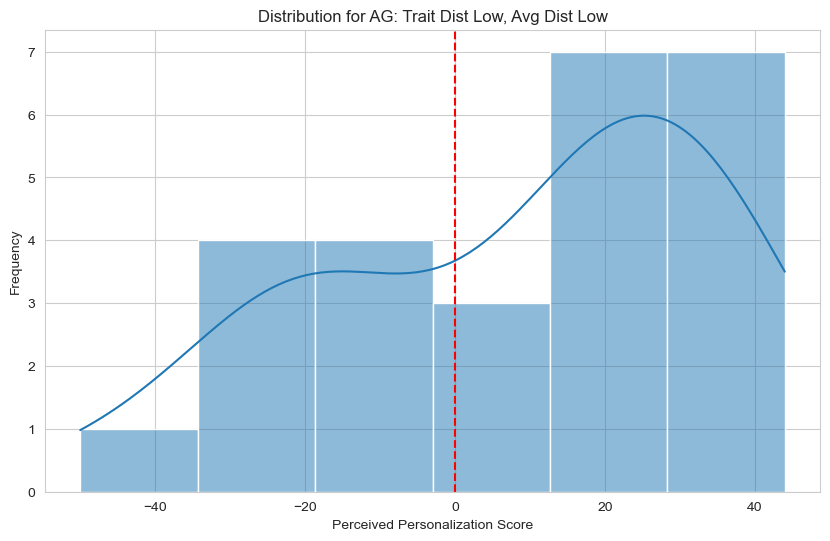


Group: Trait Distance Low, Avg Distance High
Sample size: 21
Mean score: 9.1905
95% CI: (-3.5821, 22.2381)
T-statistic: 1.3763
p-value: 0.1839
Blended preference: 62.25% (95% CI: 38.10%, 80.95%)


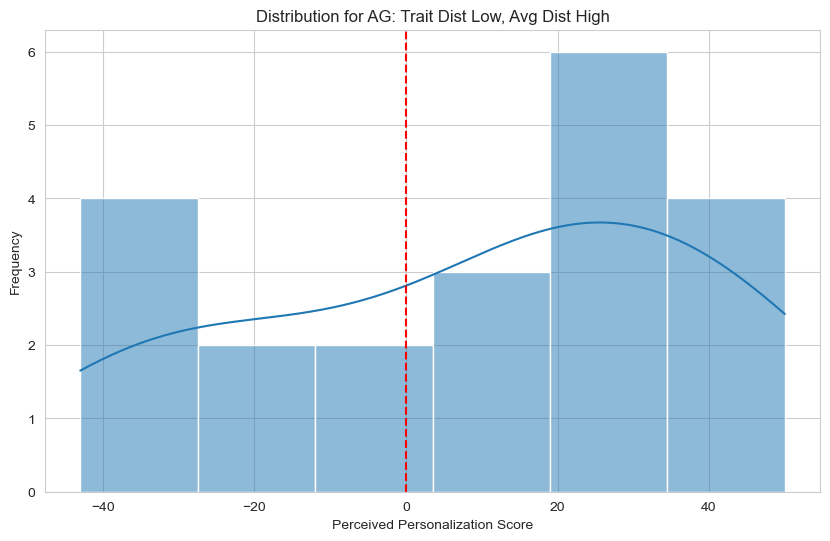


Group: Trait Distance High, Avg Distance Low
Sample size: 21
Mean score: 12.8571
95% CI: (2.9036, 22.6214)
T-statistic: 2.4769
p-value: 0.0223
Blended preference: 71.21% (95% CI: 52.38%, 90.48%)


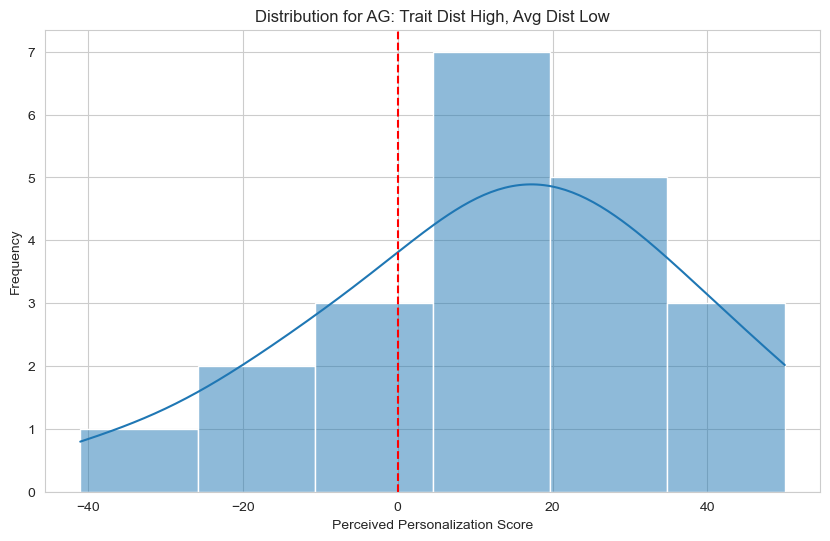


Group: Trait Distance High, Avg Distance High
Sample size: 22
Mean score: 7.1818
95% CI: (-3.3205, 18.3648)
T-statistic: 1.2900
p-value: 0.2111
Blended preference: 72.47% (95% CI: 54.55%, 90.91%)


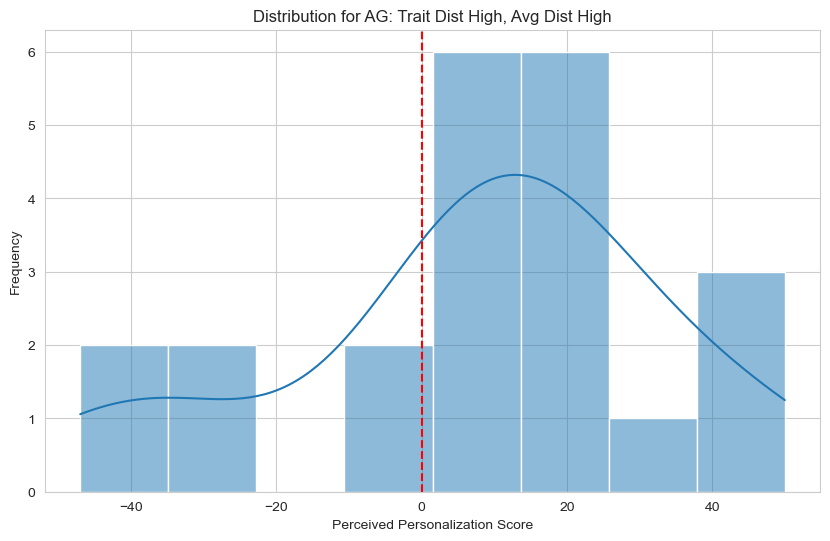


Overall Results:
Trait Trait Distance Avg Distance  N  Mean Score   CI Lower  CI Upper  T-statistic  P-value  Blended Preference  Blended Pref CI Lower  Blended Pref CI Upper
   EX            Low          Low 26   -7.000000 -18.770192  5.039423    -1.098256 0.282558            0.387538               0.192308               0.576923
   EX            Low         High 20   -3.100000 -17.301250 11.601250    -0.399754 0.693796            0.449900               0.250000               0.650000
   EX           High          Low 21   10.904762  -3.666667 23.428571     1.530987 0.141438            0.708667               0.523810               0.857143
   EX           High         High 23   13.739130   0.476087 25.392391     2.110953 0.046371            0.608739               0.391304               0.782609
   OP            Low          Low 32   -5.125000 -16.447656  6.700781    -0.867866 0.392137            0.373844               0.218750               0.562500
   OP            Low         High 

Trait Trait Distance Avg Distance   N  Mean Score   CI Lower   CI Upper  \
0     EX            Low          Low  26   -7.000000 -18.770192   5.039423   
1     EX            Low         High  20   -3.100000 -17.301250  11.601250   
2     EX           High          Low  21   10.904762  -3.666667  23.428571   
3     EX           High         High  23   13.739130   0.476087  25.392391   
4     OP            Low          Low  32   -5.125000 -16.447656   6.700781   
5     OP            Low         High  16  -16.875000 -30.190625  -1.371875   
6     OP           High          Low  15   -8.133333 -20.868333   4.266667   
7     OP           High         High  27    0.407407 -11.484259  13.112037   
8     CO            Low          Low  27   -2.592593 -12.964815   8.486111   
9     CO            Low         High  23   -4.391304 -17.959783  10.263043   
10    CO           High          Low  20   -0.400000 -11.450000  11.801250   
11    CO           High         High  20    0.650000 -13.001250  14.201250   
12    AG            Low          Low  26    8.192308  -1.847115  17.961538   
13    AG            Low         High  21    9.190476  -3.582143  22.238095   
14    AG           High          Low  21   12.857143   2.903571  22.621429   
15    AG           High         High  22    7.181818  -3.320455  18.364773   

    T-statistic   P-value  Blended Preference  Blended Pref CI Lower  \
0     -1.098256  0.282558            0.387538               0.192308   
1     -0.399754  0.693796            0.449900               0.250000   
2      1.530987  0.141438            0.708667               0.523810   
3      2.110953  0.046371            0.608739               0.391304   
4     -0.867866  0.392137            0.373844               0.218750   
5     -2.123821  0.050726            0.312250               0.125000   
6     -1.182200  0.256817            0.463600               0.200000   
7      0.064460  0.949097            0.518630               0.333333   
8     -0.454815  0.653017            0.370259               0.185185   
9     -0.579462  0.568164            0.433652               0.260870   
10    -0.070483  0.944546            0.506700               0.300000   
11     0.086570  0.931919            0.549650               0.350000   
12     1.598341  0.122531            0.657308               0.461538   
13     1.376340  0.183932            0.622476               0.380952   
14     2.476918  0.022305            0.712095               0.523810   
15     1.290015  0.211071            0.724727               0.545455   

    Blended Pref CI Upper  
0                0.576923  
1                0.650000  
2                0.857143  
3                0.782609  
4                0.562500  
5                0.562500  
6                0.733333  
7                0.703704  
8                0.555556  
9                0.608696  
10               0.701250  
11               0.750000  
12               0.846154  
13               0.809524  
14               0.904762  
15               0.909091

In [44]:
analyze_controlled_cdf_robust(merged_df_norm, 
                              traits=['EX', 'OP', 'CO', 'AG'], 
                              n_groups=2, 
                              n_bootstrap=1000)

# sandbox 4

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

In [ ]:
# ステップ2: 全体的な選好分析
"""
各特性（EX, OP, CO, AG）について、相対的選好スコアの平均値を計算する。
一標本のt検定を使用して、各特性の平均スコアが0と有意に異なるかを検証する。
コメント: この分析により、全体としてBlended広告が好まれているか、
あるいは特定の特性でBlended広告が特に効果的かを把握できます。
"""
def overall_preference_analysis(trait):
    score = data[f'Ads_{trait}_relative_1']
    t_stat, p_value = stats.ttest_1samp(score, 0)
    print(f"{trait} - perceived personalization:")
    print(f"Mean score: {score.mean():.2f}")
    print(f"T-statistic: {t_stat:.2f}, p-value: {p_value:.4f}\n")

for trait in traits:
    overall_preference_analysis(trait)

EX - perceived personalization:
Mean score: 3.34
T-statistic: 0.95, p-value: 0.3447

OP - perceived personalization:
Mean score: -6.06
T-statistic: -1.80, p-value: 0.0755

CO - perceived personalization:
Mean score: -1.84
T-statistic: -0.56, p-value: 0.5746

AG - perceived personalization:
Mean score: 9.27
T-statistic: 3.34, p-value: 0.0012



EX - perceived personalization:
Correlation with Blended distance: r=0.23, p=0.0303
Correlation with Single Trait distance: r=0.26, p=0.0151



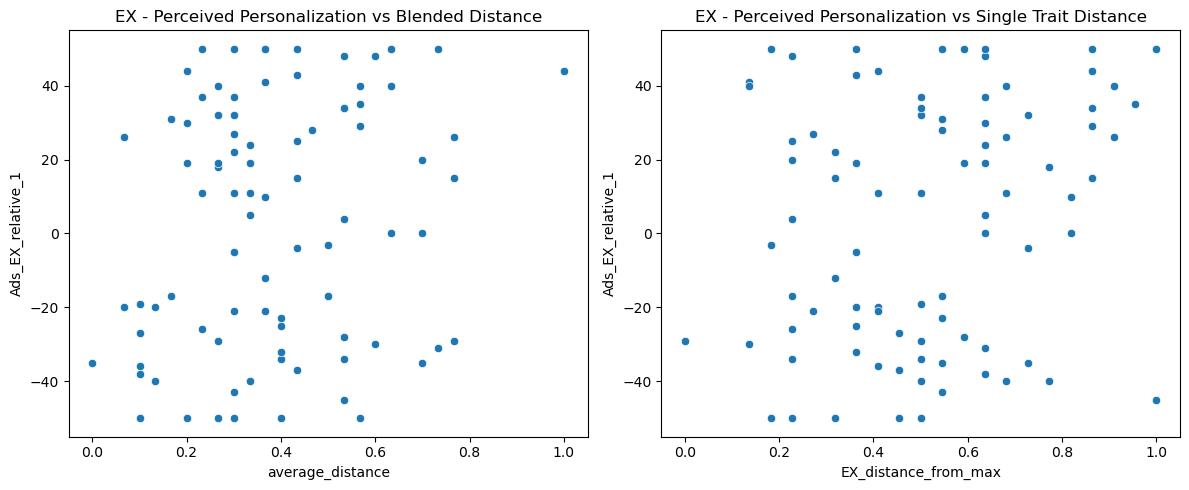

OP - perceived personalization:
Correlation with Blended distance: r=0.03, p=0.8057
Correlation with Single Trait distance: r=0.15, p=0.1675



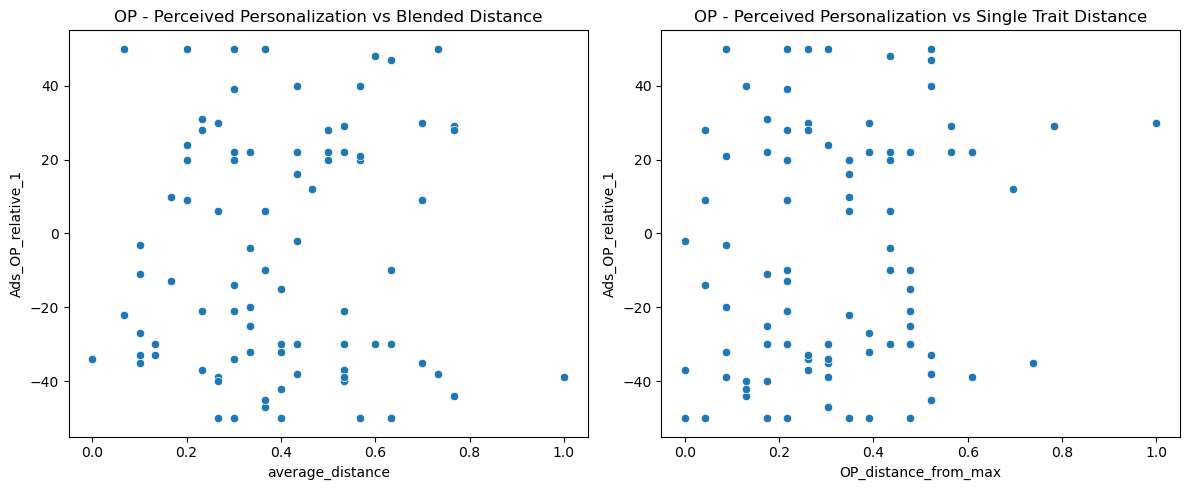

CO - perceived personalization:
Correlation with Blended distance: r=-0.00, p=0.9955
Correlation with Single Trait distance: r=0.05, p=0.6300



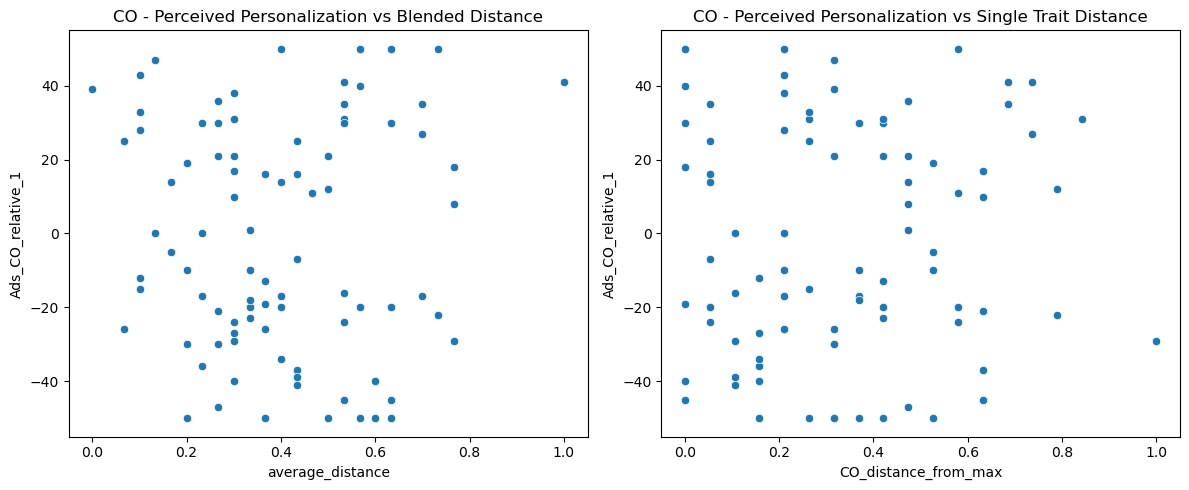

AG - perceived personalization:
Correlation with Blended distance: r=0.04, p=0.7425
Correlation with Single Trait distance: r=-0.01, p=0.9587



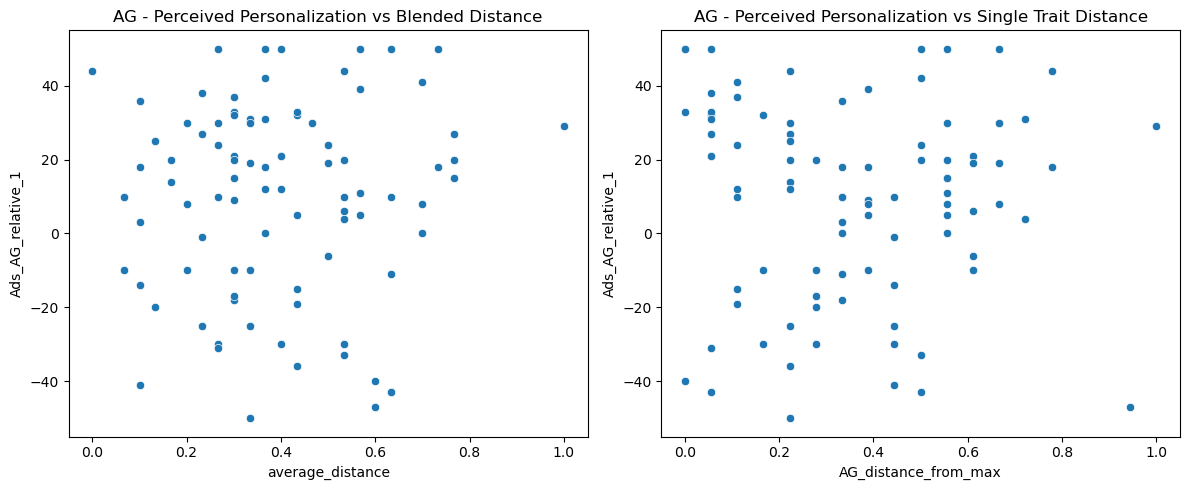

In [ ]:
# ステップ3: 距離の影響分析
"""
各参加者について、以下の2つの距離を計算する：
a) Blended personaからの距離（既に計算済みのaverage_distance）
b) Single Trait最大スコア（5）からの距離（既に計算済みの{trait}_distance_from_max）
これらの距離と相対的選好スコアの関係を散布図で可視化する。
距離と相対的選好スコアの相関分析を行う。
コメント: この分析により、参加者の特性プロファイルと広告の選好との関係を理解できます。
また、どちらの距離がより強く選好に影響しているかを把握できます。
"""
def distance_analysis(trait):
    # Blended personaからの距離との相関
    corr_blended = stats.pearsonr(data['average_distance'], data[f'Ads_{trait}_relative_1'])
    
    # Single Trait最大スコアからの距離との相関
    corr_single = stats.pearsonr(data[f'{trait}_distance_from_max'], data[f'Ads_{trait}_relative_1'])
    
    print(f"{trait} - perceived personalization:")
    print(f"Correlation with Blended distance: r={corr_blended[0]:.2f}, p={corr_blended[1]:.4f}")
    print(f"Correlation with Single Trait distance: r={corr_single[0]:.2f}, p={corr_single[1]:.4f}\n")
    
    # 散布図
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x='average_distance', y=f'Ads_{trait}_relative_1', data=data)
    plt.title(f"{trait} - Perceived Personalization vs Blended Distance")
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=f'{trait}_distance_from_max', y=f'Ads_{trait}_relative_1', data=data)
    plt.title(f"{trait} - Perceived Personalization vs Single Trait Distance")
    plt.tight_layout()
    plt.show()

for trait in traits:
    distance_analysis(trait)

EX - Perceived Personalization グループ平均:
EX_single_segment      near     middle        far
blended_segment                                  
near              -7.125000  -6.842105  25.400000
middle             0.133333  11.875000  -4.800000
far                3.300000  -4.000000  21.769231

EX - Perceived Personalization 二元配置分散分析結果:
                                               sum_sq    df         F  \
C(blended_segment)                         687.531217   2.0  0.315852   
C(EX_single_segment)                      4229.398706   2.0  1.942987   
C(blended_segment):C(EX_single_segment)   4849.562524   4.0  1.113945   
Residual                                 88158.417341  81.0       NaN   

                                           PR(>F)  
C(blended_segment)                       0.730061  
C(EX_single_segment)                     0.149895  
C(blended_segment):C(EX_single_segment)  0.355726  
Residual                                      NaN  

Kruskal-Wallis test results:
Blended seg

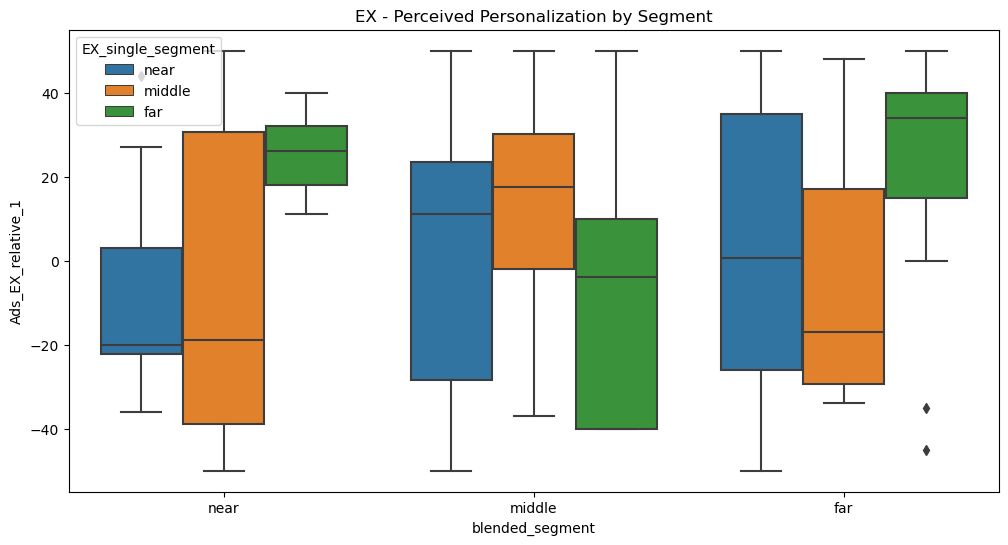



OP - Perceived Personalization グループ平均:
OP_single_segment       near    middle        far
blended_segment                                  
near                0.615385 -7.562500 -20.333333
middle             -8.583333 -6.833333 -12.700000
far               -23.200000 -0.666667   7.882353

OP - Perceived Personalization 二元配置分散分析結果:
                                               sum_sq    df         F  \
C(blended_segment)                         545.177888   2.0  0.266845   
C(OP_single_segment)                       870.980983   2.0  0.426314   
C(blended_segment):C(OP_single_segment)   6604.105364   4.0  1.616236   
Residual                                 82743.562462  81.0       NaN   

                                           PR(>F)  
C(blended_segment)                       0.766462  
C(OP_single_segment)                     0.654368  
C(blended_segment):C(OP_single_segment)  0.178125  
Residual                                      NaN  

Kruskal-Wallis test results:
Blended s

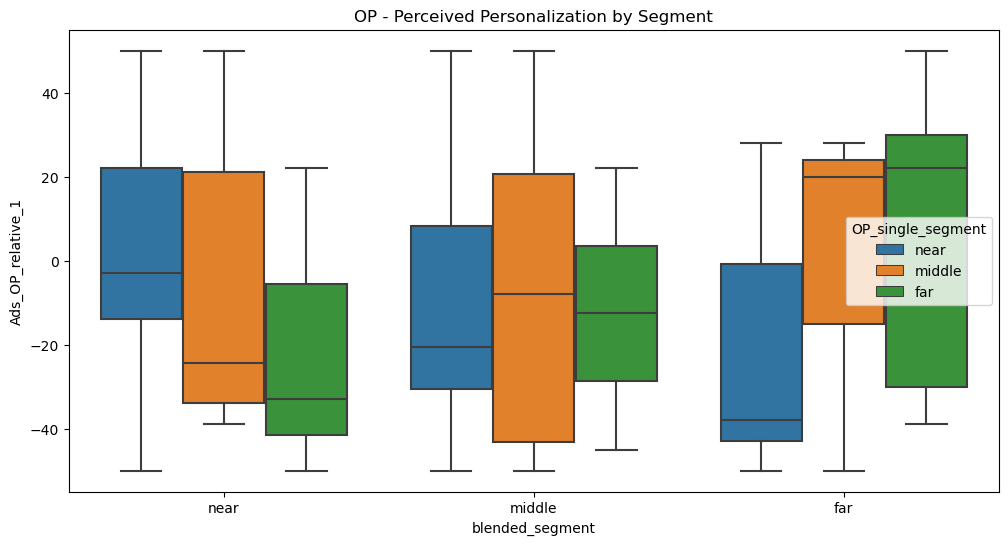



CO - Perceived Personalization グループ平均:
CO_single_segment      near     middle        far
blended_segment                                  
near              -2.500000   6.785714   4.250000
middle            -8.937500 -15.500000 -12.500000
far                4.727273 -19.333333   8.076923

CO - Perceived Personalization 二元配置分散分析結果:
                                               sum_sq    df         F  \
C(blended_segment)                        3549.700477   2.0  1.835519   
C(CO_single_segment)                       716.571248   2.0  0.370533   
C(blended_segment):C(CO_single_segment)   3280.341119   4.0  0.848118   
Residual                                 78322.732871  81.0       NaN   

                                           PR(>F)  
C(blended_segment)                       0.166104  
C(CO_single_segment)                     0.691531  
C(blended_segment):C(CO_single_segment)  0.498858  
Residual                                      NaN  

Kruskal-Wallis test results:
Blended s

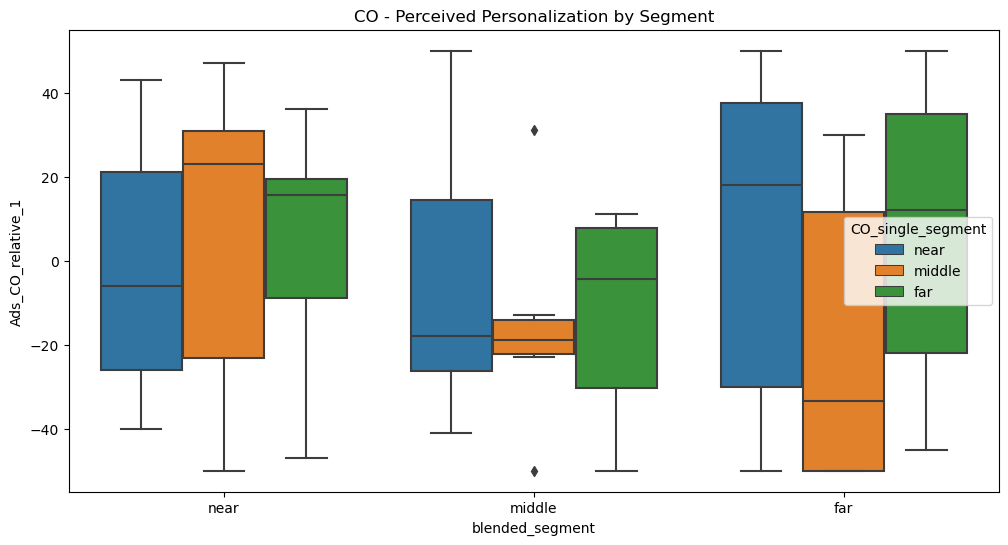



AG - Perceived Personalization グループ平均:
AG_single_segment       near    middle        far
blended_segment                                  
near               15.916667 -0.437500  14.500000
middle              8.600000  7.142857  27.666667
far                13.571429 -3.000000  11.733333

AG - Perceived Personalization 二元配置分散分析結果:
                                               sum_sq    df         F  \
C(blended_segment)                         428.485786   2.0  0.308816   
C(AG_single_segment)                      3790.920933   2.0  2.732169   
C(blended_segment):C(AG_single_segment)   1464.135614   4.0  0.527611   
Residual                                 56194.292262  81.0       NaN   

                                           PR(>F)  
C(blended_segment)                       0.735177  
C(AG_single_segment)                     0.071079  
C(blended_segment):C(AG_single_segment)  0.715732  
Residual                                      NaN  

Kruskal-Wallis test results:
Blended s

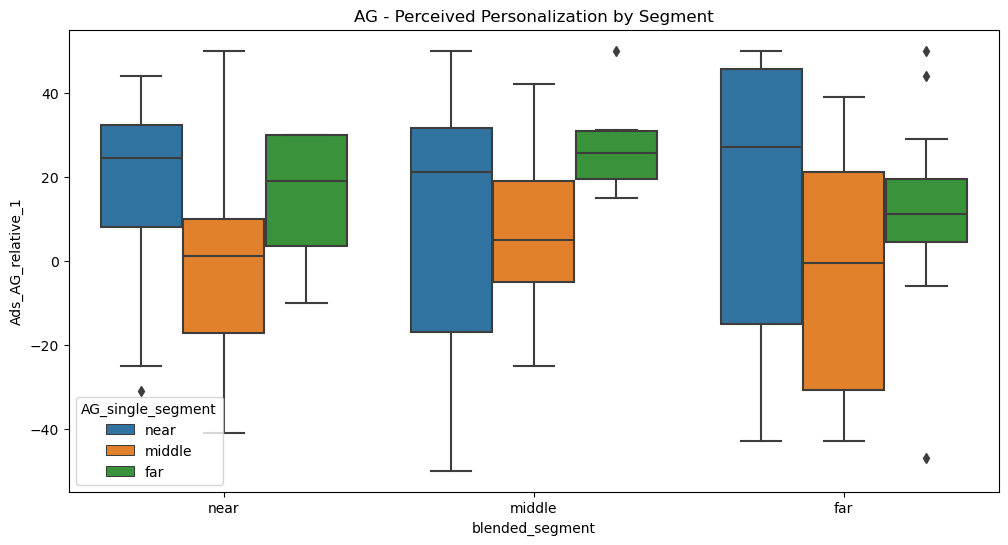

In [ ]:
# ステップ5: セグメント分析
"""
参加者を以下の2つの距離に基づいて分類する：
a) Blended personaからの距離（average_distance）
b) Single Trait最大スコア（5）からの距離
各距離について、参加者を3つのグループ（近い、中間、遠い）に分類する。

各グループ内で、相対的選好スコアの平均を計算し、グループ間で比較する。
Tukey's Honest Significant Difference (HSD) テストを使用することができます。
これは、多重比較の問題を考慮しつつ、すべてのグループペア間の差の有意性を検定する方法です。

二元配置分散分析（Two-way ANOVA）を使用して、Blended距離とSingle Trait距離の両方が
相対的選好スコアに与える影響を分析する。
コメント: この修正により、Blended personaからの距離とSingle Trait最大スコアからの
距離の両方を考慮したセグメント分析が可能になります。
これにより、どのような特性プロファイルを持つ人々にBlended広告が特に効果的か、
あるいはSingleが効果的かをより詳細に理解できます。
"""

def segment_analysis_robust(trait, data, n_segments=3):
    # セグメントのラベルを3つに変更
    segment_labels = ['near', 'middle', 'far']
    
    data['blended_segment'] = pd.qcut(data['average_distance'], q=n_segments, labels=segment_labels)
    data[f'{trait}_single_segment'] = pd.qcut(data[f'{trait}_distance_from_max'], q=n_segments, labels=segment_labels)
    
    # グループごとの平均スコア計算
    grouped_means = data.groupby(['blended_segment', f'{trait}_single_segment'])[f'Ads_{trait}_relative_1'].mean().unstack()
    print(f"{trait} - Perceived Personalization グループ平均:")
    print(grouped_means)
    print()
    
    # 二元配置分散分析
    model = ols(f'Ads_{trait}_relative_1 ~ C(blended_segment) + C({trait}_single_segment) + C(blended_segment):C({trait}_single_segment)', data=data).fit()
    anova_table = anova_lm(model, typ=2)
    print(f"{trait} - Perceived Personalization 二元配置分散分析結果:")
    print(anova_table)
    print()
    
    # Kruskal-Wallis検定（ノンパラメトリック検定）
    kruskal_blended = kruskal(*[group[f'Ads_{trait}_relative_1'].values for name, group in data.groupby('blended_segment')])
    kruskal_single = kruskal(*[group[f'Ads_{trait}_relative_1'].values for name, group in data.groupby(f'{trait}_single_segment')])
    
    print("Kruskal-Wallis test results:")
    print(f"Blended segment: H-statistic = {kruskal_blended.statistic:.4f}, p-value = {kruskal_blended.pvalue:.4f}")
    print(f"Single trait segment: H-statistic = {kruskal_single.statistic:.4f}, p-value = {kruskal_single.pvalue:.4f}")
    print()
    
    # 効果量の計算（Cohen's d）
    def cohens_d(group1, group2):
        n1, n2 = len(group1), len(group2)
        var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
        pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
        return (np.mean(group1) - np.mean(group2)) / pooled_se

    blended_groups = [group[f'Ads_{trait}_relative_1'].values for name, group in data.groupby('blended_segment')]
    single_groups = [group[f'Ads_{trait}_relative_1'].values for name, group in data.groupby(f'{trait}_single_segment')]
    
    print("Effect sizes (Cohen's d):")
    print(f"Blended segment (近い vs 遠い): {cohens_d(blended_groups[0], blended_groups[-1]):.4f}")
    print(f"Single trait segment (近い vs 遠い): {cohens_d(single_groups[0], single_groups[-1]):.4f}")
    print()
    
    # データの可視化
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='blended_segment', y=f'Ads_{trait}_relative_1', hue=f'{trait}_single_segment', data=data)
    plt.title(f'{trait} - Perceived Personalization by Segment')
    plt.show()
    
    print("\n" + "="*50 + "\n")

for trait in traits:
    segment_analysis_robust(trait, merged_df_norm)